In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    confusion_matrix as sk_confusion_matrix,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.preprocessing import StandardScaler
import logging
import time
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from catboost import CatBoostClassifier
from tensorflow.keras.utils import to_categorical 
import tensorflow as tf 
import logging
import gc 
import matplotlib.pyplot as plt

In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [4]:
ENSEMBLE_WEIGHTS = [0.4, 0.3, 0.3]
num_classes = 3
epochs = 50
batch_size = 16
learning_rate = 0.001
all_possible_labels = list(range(num_classes))

In [5]:
def create_cnn_model_1(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    conv1 = Conv1D(filters=10, kernel_size=6, activation='relu', padding='same')(input_layer)
    conv2 = Conv1D(filters=10, kernel_size=6, activation='relu', padding='same')(conv1)
    pool = MaxPooling1D(pool_size=2, padding='same')(conv2)
    flatten = Flatten()(pool)
    dense1 = Dense(units=8, activation='relu')(flatten)
    output_layer = Dense(units=num_classes, activation='softmax', name='ecn2_output')(dense1)
    return Model(inputs=input_layer, outputs=output_layer)


def create_cnn_model_2(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    conv1 = Conv1D(filters=10, kernel_size=6, activation='relu', padding='same')(input_layer)
    conv2 = Conv1D(filters= 10, kernel_size=6, activation='relu', padding='same')(conv1)
    pool = MaxPooling1D(pool_size=2, padding='same')(conv2)
    flatten = Flatten()(pool)
    dense1 = Dense(units=8, activation='relu')(flatten)
    dropout1 = Dropout(0.5)(dense1)
    output_layer = Dense(units=num_classes, activation='softmax', name='ecn2_output')(dropout1)
    return Model(inputs=input_layer, outputs=output_layer)


def create_cnn_model_3(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    conv1 = Conv1D(filters=10, kernel_size=6, activation='relu', padding='same')(input_layer)
    conv2 = Conv1D(filters=10, kernel_size=6, activation='relu', padding='same')(conv1)
    pool = MaxPooling1D(pool_size=2, padding='same')(conv2)
    flatten = Flatten()(pool)
    output_layer = Dense(units=num_classes, activation='softmax', name='ecn3_output')(flatten)
    return Model(inputs=input_layer, outputs=output_layer)

In [6]:
def weighted_ensemble_predictions(predictions, weights):
    if len(predictions) != len(weights):
        raise ValueError("Number of models must match number of weights")
    weighted_predictions = np.array([predictions[i] * weights[i] for i in range(len(predictions))])
    ensemble_predictions = np.sum(weighted_predictions, axis=0)
    ensemble_predictions = np.argmax(ensemble_predictions, axis=1)
    return ensemble_predictions

In [7]:
def train_and_evaluate_cnn_ensemble(X_train, y_train, X_val, y_val, params):
    logging.info("Training CNN Ensemble...")

    X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else np.array(X_train)
    y_train_np = y_train.values if isinstance(y_train, pd.Series) else np.array(y_train)
    X_val_np = X_val.values if isinstance(X_val, pd.DataFrame) else np.array(X_val)
    y_val_np = y_val.values if isinstance(y_val, pd.Series) else np.array(y_val)

    y_train_np = y_train_np.astype(int)
    y_val_np = y_val_np.astype(int)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_np)
    X_val_scaled = scaler.transform(X_val_np)

    X_train_reshaped = np.expand_dims(X_train_scaled, axis=-1).astype(np.float32)
    X_val_reshaped = np.expand_dims(X_val_scaled, axis=-1).astype(np.float32)

    if X_train_reshaped.shape[1] == 0:
        logging.error("Error: X_train has 0 features after preprocessing/selection.")
        return None 
    input_shape = (X_train_reshaped.shape[1], 1)


    y_train_categorical = to_categorical(y_train_np, num_classes=num_classes)
    y_val_categorical = to_categorical(y_val_np, num_classes=num_classes) 

    cnn_model_1 = create_cnn_model_1(input_shape, num_classes)
    cnn_model_2 = create_cnn_model_2(input_shape, num_classes)
    cnn_model_3 = create_cnn_model_3(input_shape, num_classes)

    loss_function = 'categorical_crossentropy' 

    cnn_model_1.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss=loss_function, metrics=['accuracy'])
    cnn_model_2.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss=loss_function, metrics=['accuracy'])
    cnn_model_3.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss=loss_function, metrics=['accuracy'])

    train_start_time = time.time()
    logging.info("Fitting CNN Models...")
    history1 = cnn_model_1.fit(X_train_reshaped, y_train_categorical, epochs=params['epochs'],
                    batch_size=params['batch_size'], verbose=0,
                    validation_data=(X_val_reshaped, y_val_categorical)) 

    history2 = cnn_model_2.fit(X_train_reshaped, y_train_categorical, epochs=params['epochs'],
                    batch_size=params['batch_size'], verbose=0,
                    validation_data=(X_val_reshaped, y_val_categorical))

    history3 = cnn_model_3.fit(X_train_reshaped, y_train_categorical, epochs=params['epochs'],
                    batch_size=params['batch_size'], verbose=0,
                    validation_data=(X_val_reshaped, y_val_categorical))
    
    train_end_time = time.time()
    training_time = train_end_time - train_start_time
    logging.info(f"CNN Ensemble trained in {training_time:.2f} seconds.")
    
    predict_start_time = time.time()
    logging.info("Predicting with CNN Models...")
    cnn_predictions_1 = cnn_model_1.predict(X_val_reshaped, batch_size=params['batch_size'], verbose=0)
    cnn_predictions_2 = cnn_model_2.predict(X_val_reshaped, batch_size=params['batch_size'], verbose=0)
    cnn_predictions_3 = cnn_model_3.predict(X_val_reshaped, batch_size=params['batch_size'], verbose=0)

    ensemble_predictions = weighted_ensemble_predictions(
        [cnn_predictions_1, cnn_predictions_2, cnn_predictions_3], ENSEMBLE_WEIGHTS)
    
    predict_end_time = time.time()
    prediction_time = predict_end_time - predict_start_time
    logging.info(f"CNN Ensemble predicted in {prediction_time:.2f} seconds.")
    
    
    logging.info("Calculating Evaluation Metrics...")
    try:
        metrics = {
            'accuracy': accuracy_score(y_val_np, ensemble_predictions),
            'precision': precision_score(y_val_np, ensemble_predictions, average='macro', zero_division=0),
            'recall': recall_score(y_val_np, ensemble_predictions, average='macro', zero_division=0),
            'f1_score': f1_score(y_val_np, ensemble_predictions, average='macro', zero_division=0),
            'confusion_matrix': sk_confusion_matrix(y_val_np, ensemble_predictions,labels=all_possible_labels).tolist(),
        }
        logging.info(f"Evaluation metrics: {metrics}")
    except Exception as e:
        logging.error(f"Error calculating metrics: {e}")
        metrics = None 
        
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(history1.history['loss'], label='Model 1 - Train Loss')
    plt.plot(history1.history['val_loss'], label='Model 1 - Val Loss', linestyle='--')
    plt.plot(history2.history['loss'], label='Model 2 - Train Loss')
    plt.plot(history2.history['val_loss'], label='Model 2 - Val Loss', linestyle='--')
    plt.plot(history3.history['loss'], label='Model 3 - Train Loss')
    plt.plot(history3.history['val_loss'], label='Model 3 - Val Loss', linestyle='--')
    
    plt.title("Training and Validation Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    logging.info("Cleaning up models...")
    del cnn_model_1, cnn_model_2, cnn_model_3
    del cnn_predictions_1, cnn_predictions_2, cnn_predictions_3
    tf.keras.backend.clear_session() 
    gc.collect() 

    return metrics, training_time, prediction_time, [history1, history2, history3]

In [8]:
def load_and_preprocess_data_and_split(data_path, target_column='target'):

    logging.info(f"Loading data from: {data_path}")

    data = pd.read_csv(data_path)
    data = data.drop(columns='Unnamed: 0', errors='ignore')
    data = data.fillna(data.mean())
    print(data.shape)
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    logging.info("Data loaded and preprocessed.")
    logging.info(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}")
    return data, X_train, y_train, X_val, y_val

In [9]:
def reduce_dimensionality(X, y, top_n_features=50, save_path='reduced_data.pkl'):
    start_time = time.time()
    logging.info("Starting dimensionality reduction...")

    if save_path and os.path.exists(save_path):
        logging.info(f"Loading reduced data from: {save_path}")
        saved_data = pd.read_pickle(save_path)
        X_reduced = saved_data['X']
        selected_features = saved_data['features']
        logging.info(f"Loaded reduced data from {save_path} in {time.time() - start_time:.2f} seconds.")
        return X_reduced, selected_features


    from catboost import CatBoostClassifier
    model = CatBoostClassifier(iterations=200, 
                               depth=4, 
                               learning_rate=0.1,
                               l2_leaf_reg=10,
                               loss_function='MultiClass',
                               verbose=1, 
                               random_seed=42,
                               early_stopping_rounds=200,
                               task_type='GPU')
    model.fit(X, y, verbose=1)
    importance_df = pd.DataFrame({'feature': X.columns,
                                  'importance': model.get_feature_importance()})
    top_features_catboost = importance_df.nlargest(top_n_features,
                                                 'importance')['feature'].tolist()

    import shap
    logging.info("Calculating SHAP values...")
    top_features_shap = None
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)

        if isinstance(shap_values, list):
            logging.info("SHAP values appear to be multiclass (list).")
            if not shap_values:
                 raise ValueError("SHAP explainer returned an empty list.")
            shap_values = [np.array(vals) for vals in shap_values]

            shapes_in_list = [vals.shape for vals in shap_values]
            logging.info(f"Shapes within SHAP values list: {shapes_in_list}")

            shap_class_importance = [np.abs(vals).mean(axis=0) for vals in shap_values]
            shap_importance = np.mean(shap_class_importance, axis=0)
        elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
            logging.info(f"SHAP values: Multiclass (3D Array), Shape: {shap_values.shape}")
            shap_importance = np.abs(shap_values).mean(axis=(0, 2)) 
        else:
            if not isinstance(shap_values, np.ndarray):
                 raise TypeError(f"Expected shap_values to be list or numpy array, got {type(shap_values)}")

            logging.info(f"SHAP values appear to be binary/regression (shape: {shap_values.shape}).") # Debug log
            shap_importance = np.abs(shap_values).mean(axis=0)
  
        logging.info(f"Type of shap_importance: {type(shap_importance)}")
        logging.info(f"Shape of shap_importance: {np.array(shap_importance).shape}")
        logging.info(f"Type of X.columns: {type(X.columns)}")
        logging.info(f"Shape of X.columns: {X.columns.shape}")
        logging.info(f"Length comparison: len(X.columns)={len(X.columns)}, len(shap_importance)={len(shap_importance)}")
  
        if np.isnan(shap_importance).any() or np.isinf(shap_importance).any():
             logging.warning("NaN or Inf detected in shap_importance values.")
             shap_importance = np.nan_to_num(shap_importance, nan=0.0, posinf=0.0, neginf=0.0)


        shap_importance_df = pd.DataFrame({'feature': X.columns,
                                           'importance': shap_importance}) 

        top_features_shap = shap_importance_df.nlargest(top_n_features, 'importance')['feature'].tolist()
        logging.info("SHAP values calculated.")
        

    except Exception as e:
        logging.error(f"Error calculating SHAP values: {e}") 
        logging.warning("Using only CatBoost features due to SHAP error.")
        top_features_shap = top_features_catboost 


    selected_features = list(set(top_features_catboost) & set(top_features_shap))
    X_reduced = X[selected_features]
    

    if save_path:
        data_to_save = {'X': X_reduced, 'features': selected_features}
        pd.to_pickle(data_to_save, save_path)
        logging.info(f"Saved reduced data to {save_path}")

    logging.info(f"Dimensionality reduction completed in {time.time() - start_time:.2f} seconds.")
    
    import matplotlib.pyplot as plt
    merged_features_df = pd.DataFrame({'feature': selected_features})
    merged_features_df['catboost_importance'] = merged_features_df['feature'].map(
        {feature: importance_df.loc[importance_df['feature'] == feature, 'importance'].values[0]
            for feature in selected_features}
    )
    merged_features_df['shap_importance'] = merged_features_df['feature'].map(
        {feature: shap_importance_df.loc[shap_importance_df['feature'] == feature, 'importance'].values[0]
            for feature in selected_features}
    )
    merged_features_df['total_importance'] = merged_features_df['catboost_importance'] + \
        merged_features_df['shap_importance']
    merged_features_df = merged_features_df.sort_values(by='total_importance', ascending=False)

    plt.figure(figsize=(18, 14))
    plt.bar(merged_features_df['feature'], merged_features_df['total_importance'], color='lightcoral', edgecolor='black')
    plt.xticks(rotation=90, fontsize=24)
    plt.yticks(fontsize=24)
    plt.ylabel("Combined Importance Score (CatBoost + SHAP)", fontsize=24)
    plt.xlabel("Feature", fontsize=24)
    plt.title(f"Top {len(selected_features)} Features (Merged by CatBoost & SHAP)", fontsize=24)
    plt.tight_layout()
    plt.show()
        
    return X_reduced, selected_features, top_features_catboost, top_features_shap

2025-07-09 11:16:40,623 - INFO - Loading data from: C:/Class/HK6/IPrj/Datasets/merged_AML_ALL.csv


(3655, 22278)


2025-07-09 11:17:32,911 - INFO - Data loaded and preprocessed.
2025-07-09 11:17:32,917 - INFO - Training set shape: (2924, 22277), Validation set shape: (731, 22277)
2025-07-09 11:17:35,031 - INFO - Fold 1/10
2025-07-09 11:17:40,125 - INFO - Starting dimensionality reduction...


0:	learn: 0.9251226	total: 344ms	remaining: 1m 8s
1:	learn: 0.7940892	total: 537ms	remaining: 53.2s
2:	learn: 0.6905112	total: 735ms	remaining: 48.3s
3:	learn: 0.6058565	total: 921ms	remaining: 45.1s
4:	learn: 0.5363986	total: 1.1s	remaining: 43s
5:	learn: 0.4760299	total: 1.29s	remaining: 41.8s
6:	learn: 0.4257005	total: 1.49s	remaining: 41s
7:	learn: 0.3822649	total: 1.67s	remaining: 40.1s
8:	learn: 0.3441291	total: 1.86s	remaining: 39.6s
9:	learn: 0.3106511	total: 2.04s	remaining: 38.8s
10:	learn: 0.2809054	total: 2.23s	remaining: 38.4s
11:	learn: 0.2552617	total: 2.41s	remaining: 37.7s
12:	learn: 0.2321592	total: 2.57s	remaining: 37s
13:	learn: 0.2120127	total: 2.77s	remaining: 36.8s
14:	learn: 0.1935882	total: 2.95s	remaining: 36.4s
15:	learn: 0.1772584	total: 3.11s	remaining: 35.8s
16:	learn: 0.1627072	total: 3.3s	remaining: 35.6s
17:	learn: 0.1498740	total: 3.48s	remaining: 35.2s
18:	learn: 0.1377433	total: 3.67s	remaining: 35s
19:	learn: 0.1275167	total: 3.86s	remaining: 34.7s


2025-07-09 11:18:26,880 - INFO - Calculating SHAP values...
2025-07-09 11:19:22,554 - INFO - SHAP values: Multiclass (3D Array), Shape: (3289, 22277, 3)
2025-07-09 11:19:25,071 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 11:19:25,086 - INFO - Shape of shap_importance: (22277,)
2025-07-09 11:19:25,086 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 11:19:25,086 - INFO - Shape of X.columns: (22277,)
2025-07-09 11:19:25,086 - INFO - Length comparison: len(X.columns)=22277, len(shap_importance)=22277
2025-07-09 11:19:25,086 - INFO - SHAP values calculated.
2025-07-09 11:19:25,102 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_0.pkl
2025-07-09 11:19:25,102 - INFO - Dimensionality reduction completed in 104.98 seconds.


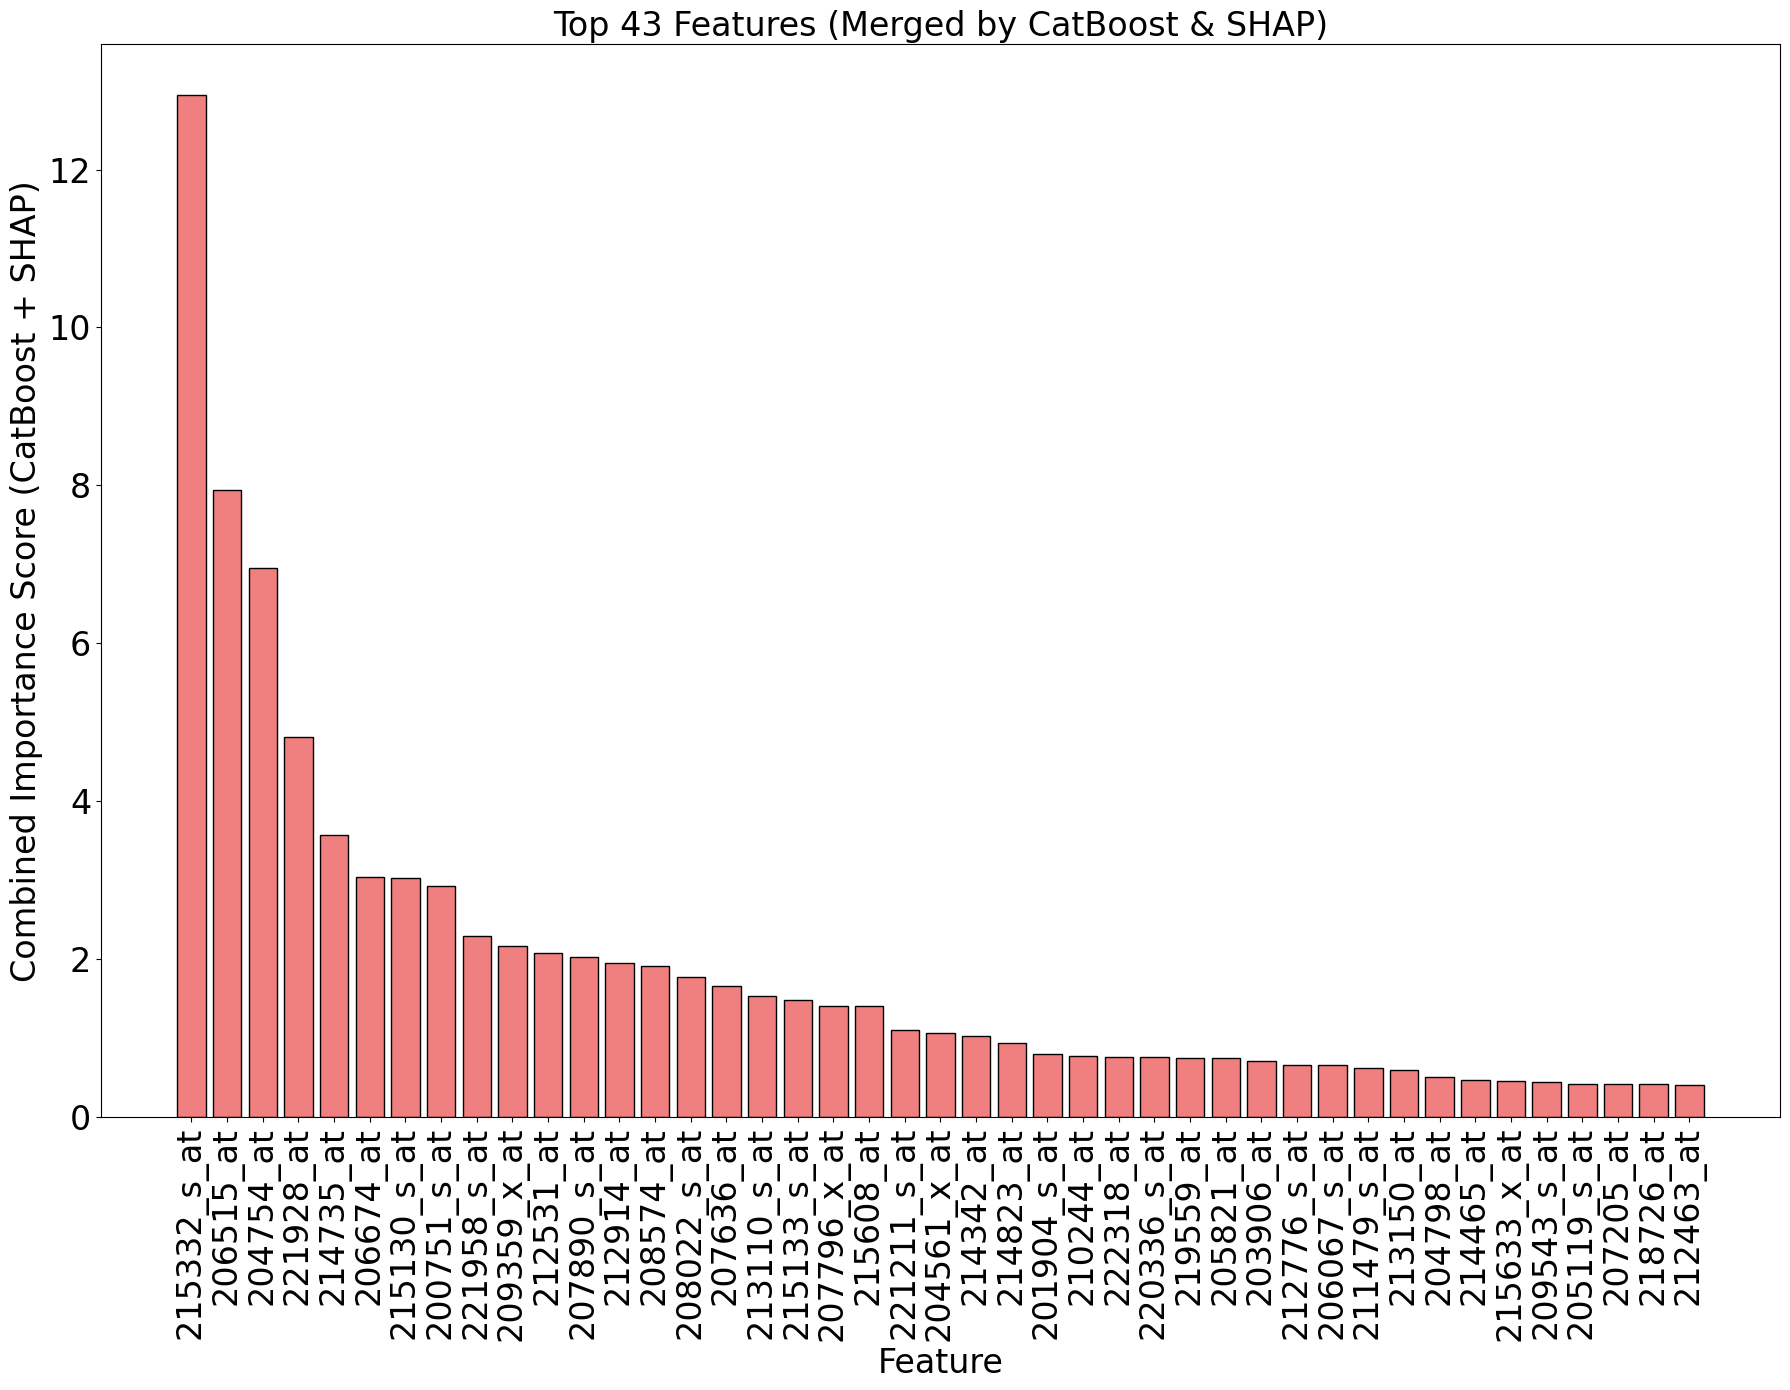

2025-07-09 11:19:26,280 - INFO - Training CNN Ensemble...
2025-07-09 11:19:26,612 - INFO - Fitting CNN Models...
2025-07-09 11:21:42,241 - INFO - CNN Ensemble trained in 135.63 seconds.
2025-07-09 11:21:42,243 - INFO - Predicting with CNN Models...
2025-07-09 11:21:43,481 - INFO - CNN Ensemble predicted in 1.24 seconds.
2025-07-09 11:21:43,481 - INFO - Calculating Evaluation Metrics...
2025-07-09 11:21:43,500 - INFO - Evaluation metrics: {'accuracy': 0.9890710382513661, 'precision': 0.9881040629743373, 'recall': 0.9881040629743373, 'f1_score': 0.9881040629743373, 'confusion_matrix': [[69, 2, 0], [2, 264, 0], [0, 0, 29]]}


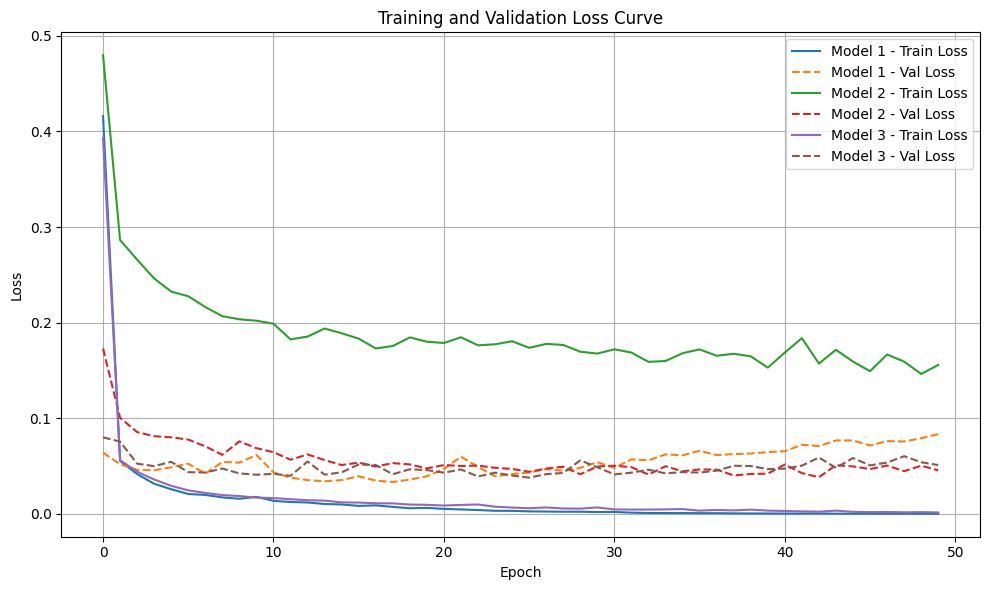

2025-07-09 11:21:43,850 - INFO - Cleaning up models...


2025-07-09 11:21:45,872 - WARNING - From c:\Class\HK6\IPrj\.venv\Lib\site-packages\keras\src\backend\common\global_state.py:82: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

2025-07-09 11:21:46,734 - INFO - Fold 2/10
2025-07-09 11:21:50,383 - INFO - Starting dimensionality reduction...


0:	learn: 0.9268614	total: 306ms	remaining: 1m
1:	learn: 0.7963815	total: 488ms	remaining: 48.3s
2:	learn: 0.6914621	total: 3.92s	remaining: 4m 17s
3:	learn: 0.6064637	total: 4.13s	remaining: 3m 22s
4:	learn: 0.5366176	total: 4.3s	remaining: 2m 47s
5:	learn: 0.4771244	total: 4.49s	remaining: 2m 25s
6:	learn: 0.4260946	total: 4.65s	remaining: 2m 8s
7:	learn: 0.3824168	total: 4.83s	remaining: 1m 55s
8:	learn: 0.3440675	total: 7.66s	remaining: 2m 42s
9:	learn: 0.3108841	total: 7.82s	remaining: 2m 28s
10:	learn: 0.2818278	total: 8.03s	remaining: 2m 17s
11:	learn: 0.2563567	total: 8.21s	remaining: 2m 8s
12:	learn: 0.2335815	total: 8.37s	remaining: 2m
13:	learn: 0.2134159	total: 8.53s	remaining: 1m 53s
14:	learn: 0.1955742	total: 11.4s	remaining: 2m 20s
15:	learn: 0.1794023	total: 11.5s	remaining: 2m 12s
16:	learn: 0.1646286	total: 11.7s	remaining: 2m 6s
17:	learn: 0.1515024	total: 11.9s	remaining: 2m
18:	learn: 0.1395773	total: 12.1s	remaining: 1m 54s
19:	learn: 0.1290867	total: 12.2s	remai

2025-07-09 11:23:59,047 - INFO - Calculating SHAP values...
2025-07-09 11:25:00,858 - INFO - SHAP values: Multiclass (3D Array), Shape: (3289, 22277, 3)
2025-07-09 11:25:03,414 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 11:25:03,416 - INFO - Shape of shap_importance: (22277,)
2025-07-09 11:25:03,420 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 11:25:03,421 - INFO - Shape of X.columns: (22277,)
2025-07-09 11:25:03,425 - INFO - Length comparison: len(X.columns)=22277, len(shap_importance)=22277
2025-07-09 11:25:03,436 - INFO - SHAP values calculated.
2025-07-09 11:25:03,449 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_1.pkl
2025-07-09 11:25:03,449 - INFO - Dimensionality reduction completed in 193.07 seconds.


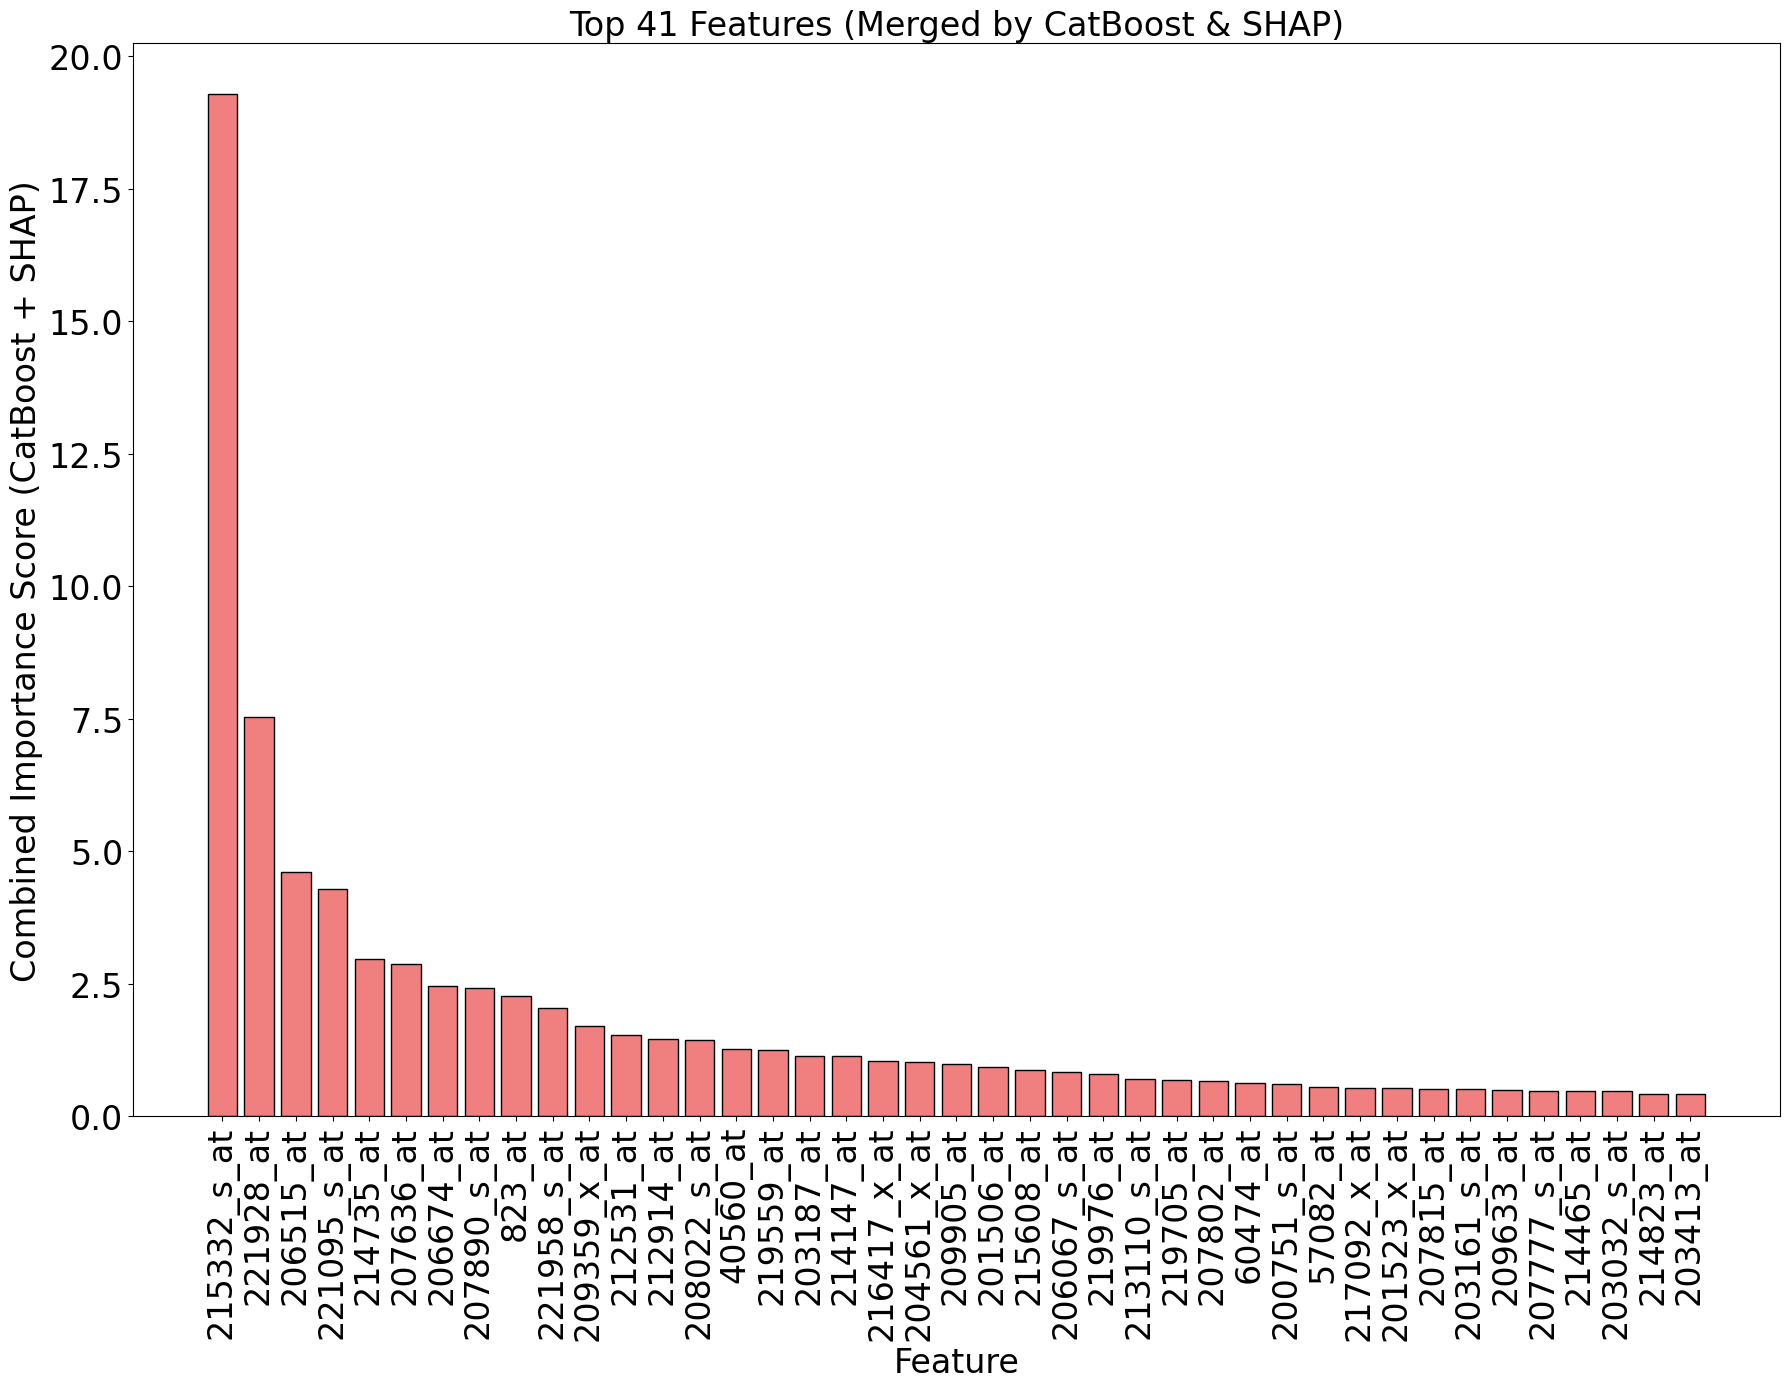

2025-07-09 11:25:04,925 - INFO - Training CNN Ensemble...
2025-07-09 11:25:05,105 - INFO - Fitting CNN Models...
2025-07-09 11:27:48,720 - INFO - CNN Ensemble trained in 163.61 seconds.
2025-07-09 11:27:48,722 - INFO - Predicting with CNN Models...
2025-07-09 11:27:50,310 - INFO - CNN Ensemble predicted in 1.59 seconds.
2025-07-09 11:27:50,311 - INFO - Calculating Evaluation Metrics...
2025-07-09 11:27:50,313 - INFO - Evaluation metrics: {'accuracy': 0.9972677595628415, 'precision': 0.9987562189054726, 'recall': 0.9953051643192489, 'f1_score': 0.9970128808466451, 'confusion_matrix': [[70, 1, 0], [0, 267, 0], [0, 0, 28]]}


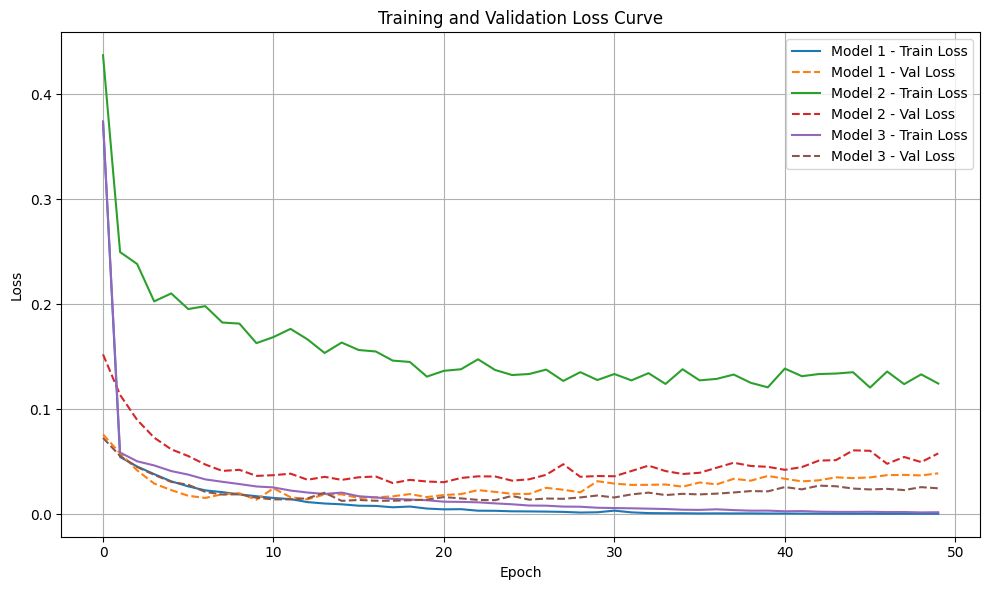

2025-07-09 11:27:50,682 - INFO - Cleaning up models...
2025-07-09 11:27:51,684 - INFO - Fold 3/10
2025-07-09 11:27:55,708 - INFO - Starting dimensionality reduction...


0:	learn: 0.9261228	total: 565ms	remaining: 1m 52s
1:	learn: 0.7952086	total: 756ms	remaining: 1m 14s
2:	learn: 0.6917193	total: 952ms	remaining: 1m 2s
3:	learn: 0.6074002	total: 1.13s	remaining: 55.2s
4:	learn: 0.5375036	total: 1.31s	remaining: 51.2s
5:	learn: 0.4780349	total: 1.48s	remaining: 47.7s
6:	learn: 0.4271401	total: 1.66s	remaining: 45.9s
7:	learn: 0.3831649	total: 1.85s	remaining: 44.3s
8:	learn: 0.3452653	total: 2.03s	remaining: 43s
9:	learn: 0.3124435	total: 2.22s	remaining: 42.2s
10:	learn: 0.2835107	total: 2.4s	remaining: 41.2s
11:	learn: 0.2576221	total: 2.58s	remaining: 40.4s
12:	learn: 0.2348640	total: 2.76s	remaining: 39.7s
13:	learn: 0.2144066	total: 2.94s	remaining: 39.1s
14:	learn: 0.1961870	total: 3.12s	remaining: 38.5s
15:	learn: 0.1798175	total: 3.29s	remaining: 37.9s
16:	learn: 0.1654552	total: 3.48s	remaining: 37.4s
17:	learn: 0.1524974	total: 3.66s	remaining: 37s
18:	learn: 0.1407348	total: 3.83s	remaining: 36.5s
19:	learn: 0.1306164	total: 4s	remaining: 36

2025-07-09 11:28:38,305 - INFO - Calculating SHAP values...


199:	learn: 0.0075022	total: 35.9s	remaining: 0us


2025-07-09 11:29:00,111 - INFO - SHAP values: Multiclass (3D Array), Shape: (3289, 22277, 3)
2025-07-09 11:29:01,443 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 11:29:01,458 - INFO - Shape of shap_importance: (22277,)
2025-07-09 11:29:01,458 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 11:29:01,458 - INFO - Shape of X.columns: (22277,)
2025-07-09 11:29:01,458 - INFO - Length comparison: len(X.columns)=22277, len(shap_importance)=22277
2025-07-09 11:29:01,458 - INFO - SHAP values calculated.
2025-07-09 11:29:01,458 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_2.pkl
2025-07-09 11:29:01,458 - INFO - Dimensionality reduction completed in 65.75 seconds.


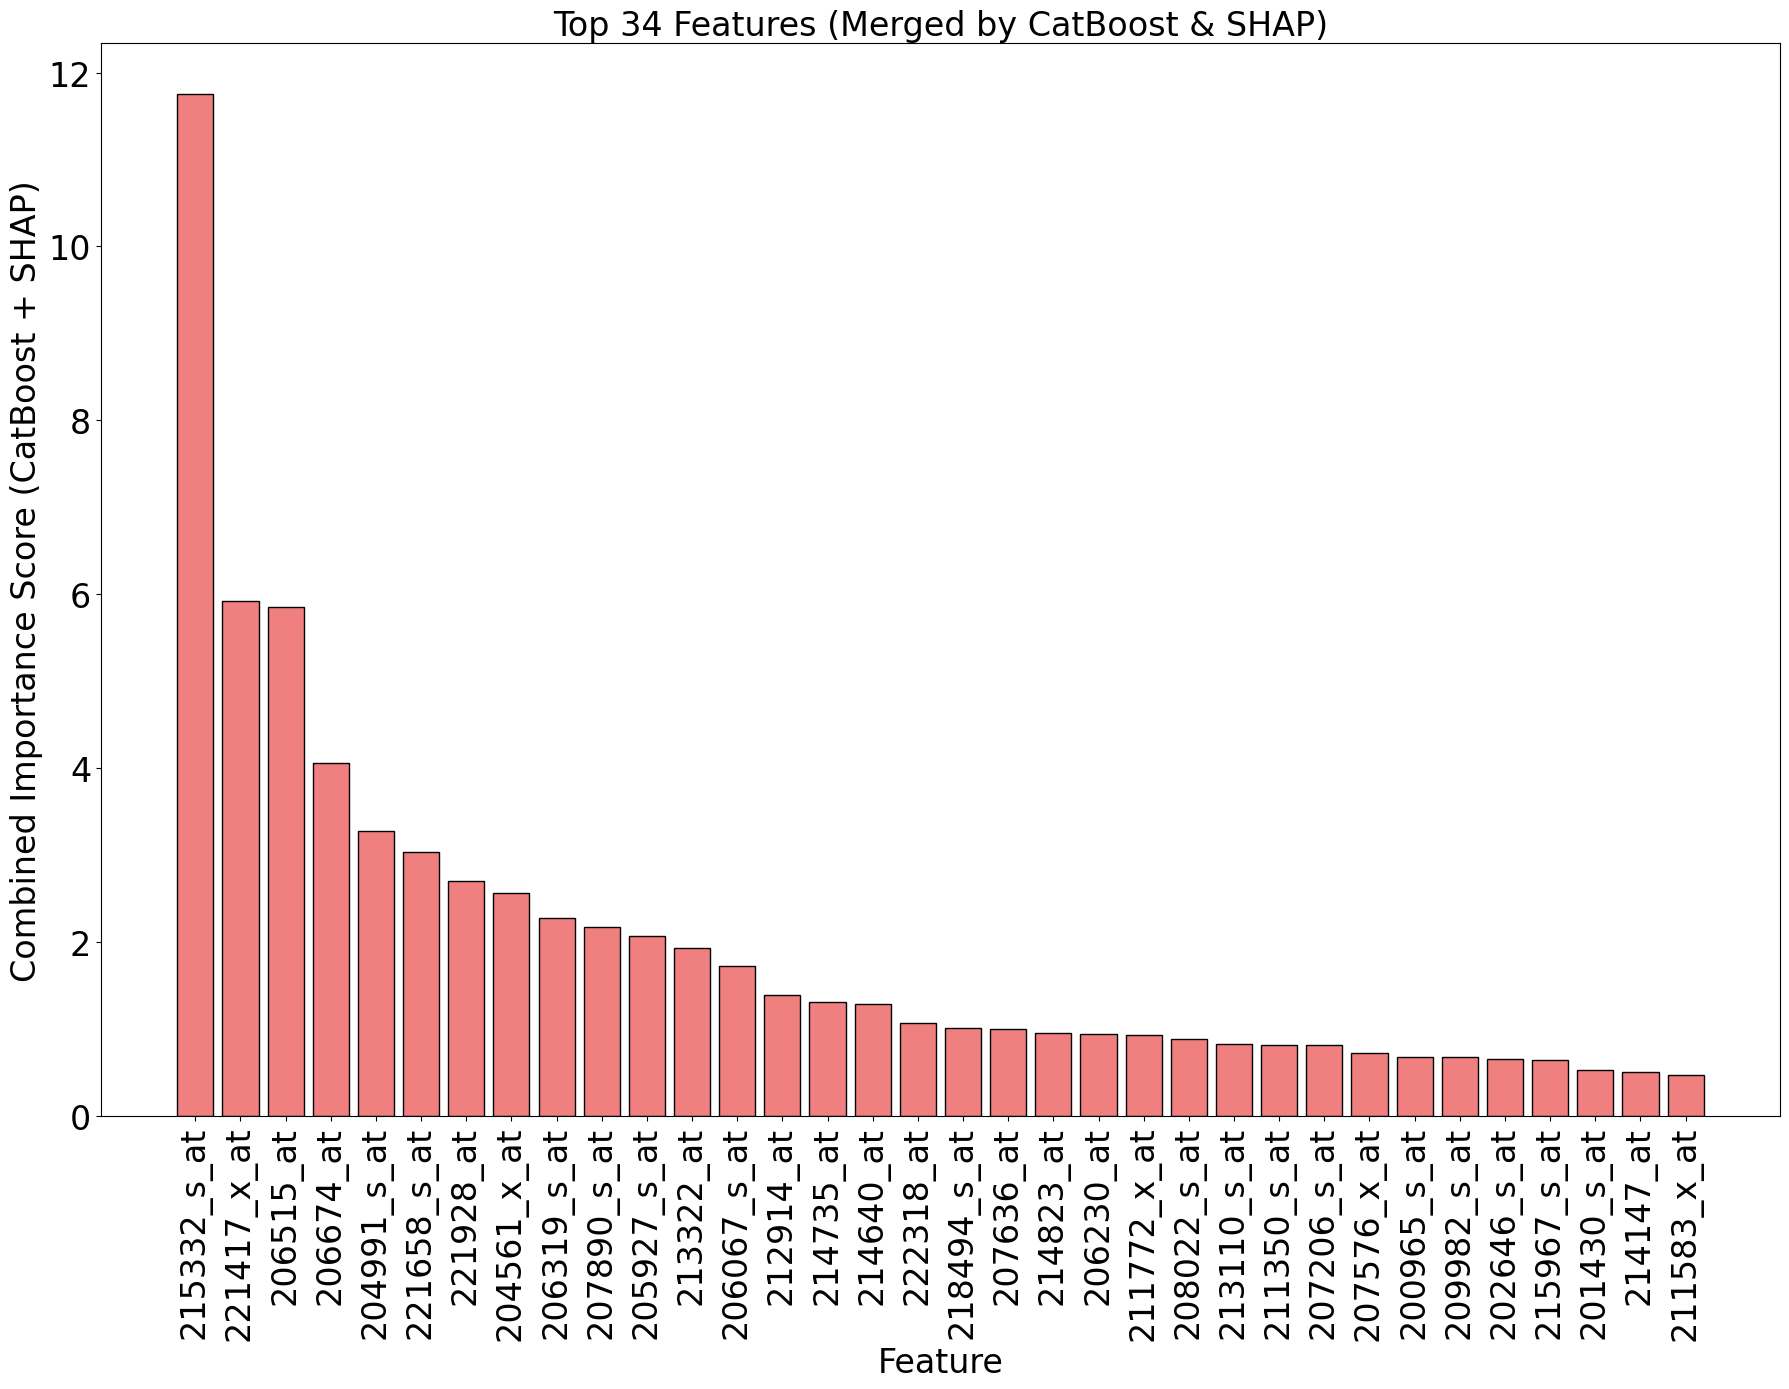

2025-07-09 11:29:01,985 - INFO - Training CNN Ensemble...
2025-07-09 11:29:02,085 - INFO - Fitting CNN Models...
2025-07-09 11:29:57,747 - INFO - CNN Ensemble trained in 55.66 seconds.
2025-07-09 11:29:57,747 - INFO - Predicting with CNN Models...
2025-07-09 11:29:58,303 - INFO - CNN Ensemble predicted in 0.56 seconds.
2025-07-09 11:29:58,303 - INFO - Calculating Evaluation Metrics...
2025-07-09 11:29:58,312 - INFO - Evaluation metrics: {'accuracy': 0.994535519125683, 'precision': 0.9940567248685621, 'recall': 0.9940567248685621, 'f1_score': 0.9940567248685621, 'confusion_matrix': [[70, 1, 0], [1, 266, 0], [0, 0, 28]]}


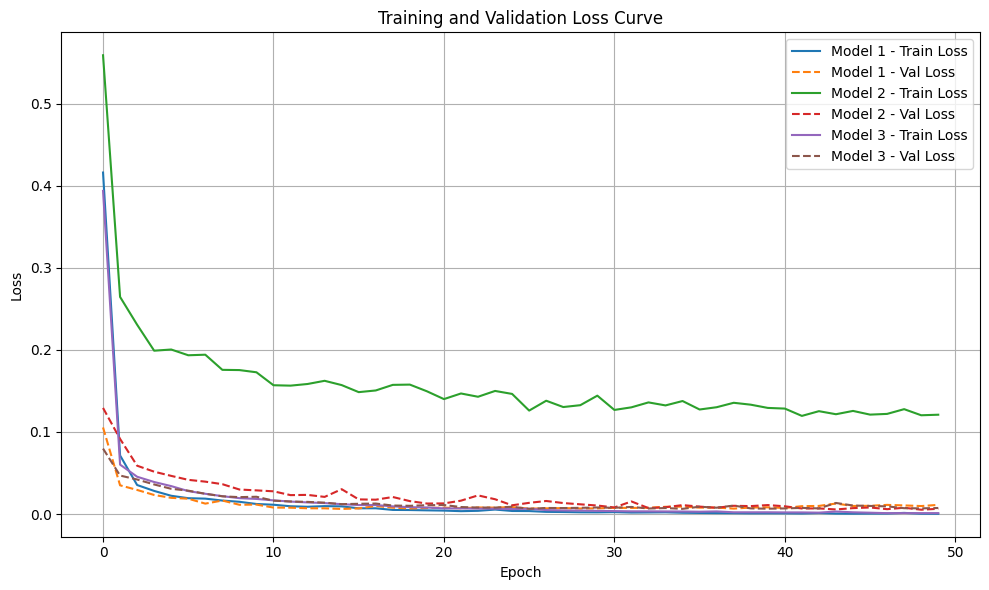

2025-07-09 11:29:58,464 - INFO - Cleaning up models...
2025-07-09 11:29:59,206 - INFO - Fold 4/10
2025-07-09 11:30:00,605 - INFO - Starting dimensionality reduction...


0:	learn: 0.9266315	total: 229ms	remaining: 45.6s
1:	learn: 0.7957552	total: 379ms	remaining: 37.5s
2:	learn: 0.6924119	total: 522ms	remaining: 34.3s
3:	learn: 0.6078271	total: 651ms	remaining: 31.9s
4:	learn: 0.5373044	total: 797ms	remaining: 31.1s
5:	learn: 0.4778492	total: 930ms	remaining: 30.1s
6:	learn: 0.4269358	total: 1.06s	remaining: 29.3s
7:	learn: 0.3823941	total: 1.2s	remaining: 28.9s
8:	learn: 0.3444698	total: 1.35s	remaining: 28.6s
9:	learn: 0.3114703	total: 1.49s	remaining: 28.3s
10:	learn: 0.2819533	total: 1.63s	remaining: 28.1s
11:	learn: 0.2557259	total: 1.77s	remaining: 27.8s
12:	learn: 0.2332237	total: 1.92s	remaining: 27.6s
13:	learn: 0.2128869	total: 2.06s	remaining: 27.4s
14:	learn: 0.1946377	total: 2.19s	remaining: 27s
15:	learn: 0.1780840	total: 2.32s	remaining: 26.7s
16:	learn: 0.1633158	total: 2.45s	remaining: 26.4s
17:	learn: 0.1503203	total: 2.58s	remaining: 26.1s
18:	learn: 0.1387107	total: 2.71s	remaining: 25.9s
19:	learn: 0.1281151	total: 2.84s	remaining:

2025-07-09 11:30:30,382 - INFO - Calculating SHAP values...
2025-07-09 11:30:50,993 - INFO - SHAP values: Multiclass (3D Array), Shape: (3289, 22277, 3)
2025-07-09 11:30:52,385 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 11:30:52,385 - INFO - Shape of shap_importance: (22277,)
2025-07-09 11:30:52,385 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 11:30:52,385 - INFO - Shape of X.columns: (22277,)
2025-07-09 11:30:52,385 - INFO - Length comparison: len(X.columns)=22277, len(shap_importance)=22277
2025-07-09 11:30:52,393 - INFO - SHAP values calculated.
2025-07-09 11:30:52,400 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_3.pkl
2025-07-09 11:30:52,400 - INFO - Dimensionality reduction completed in 51.79 seconds.


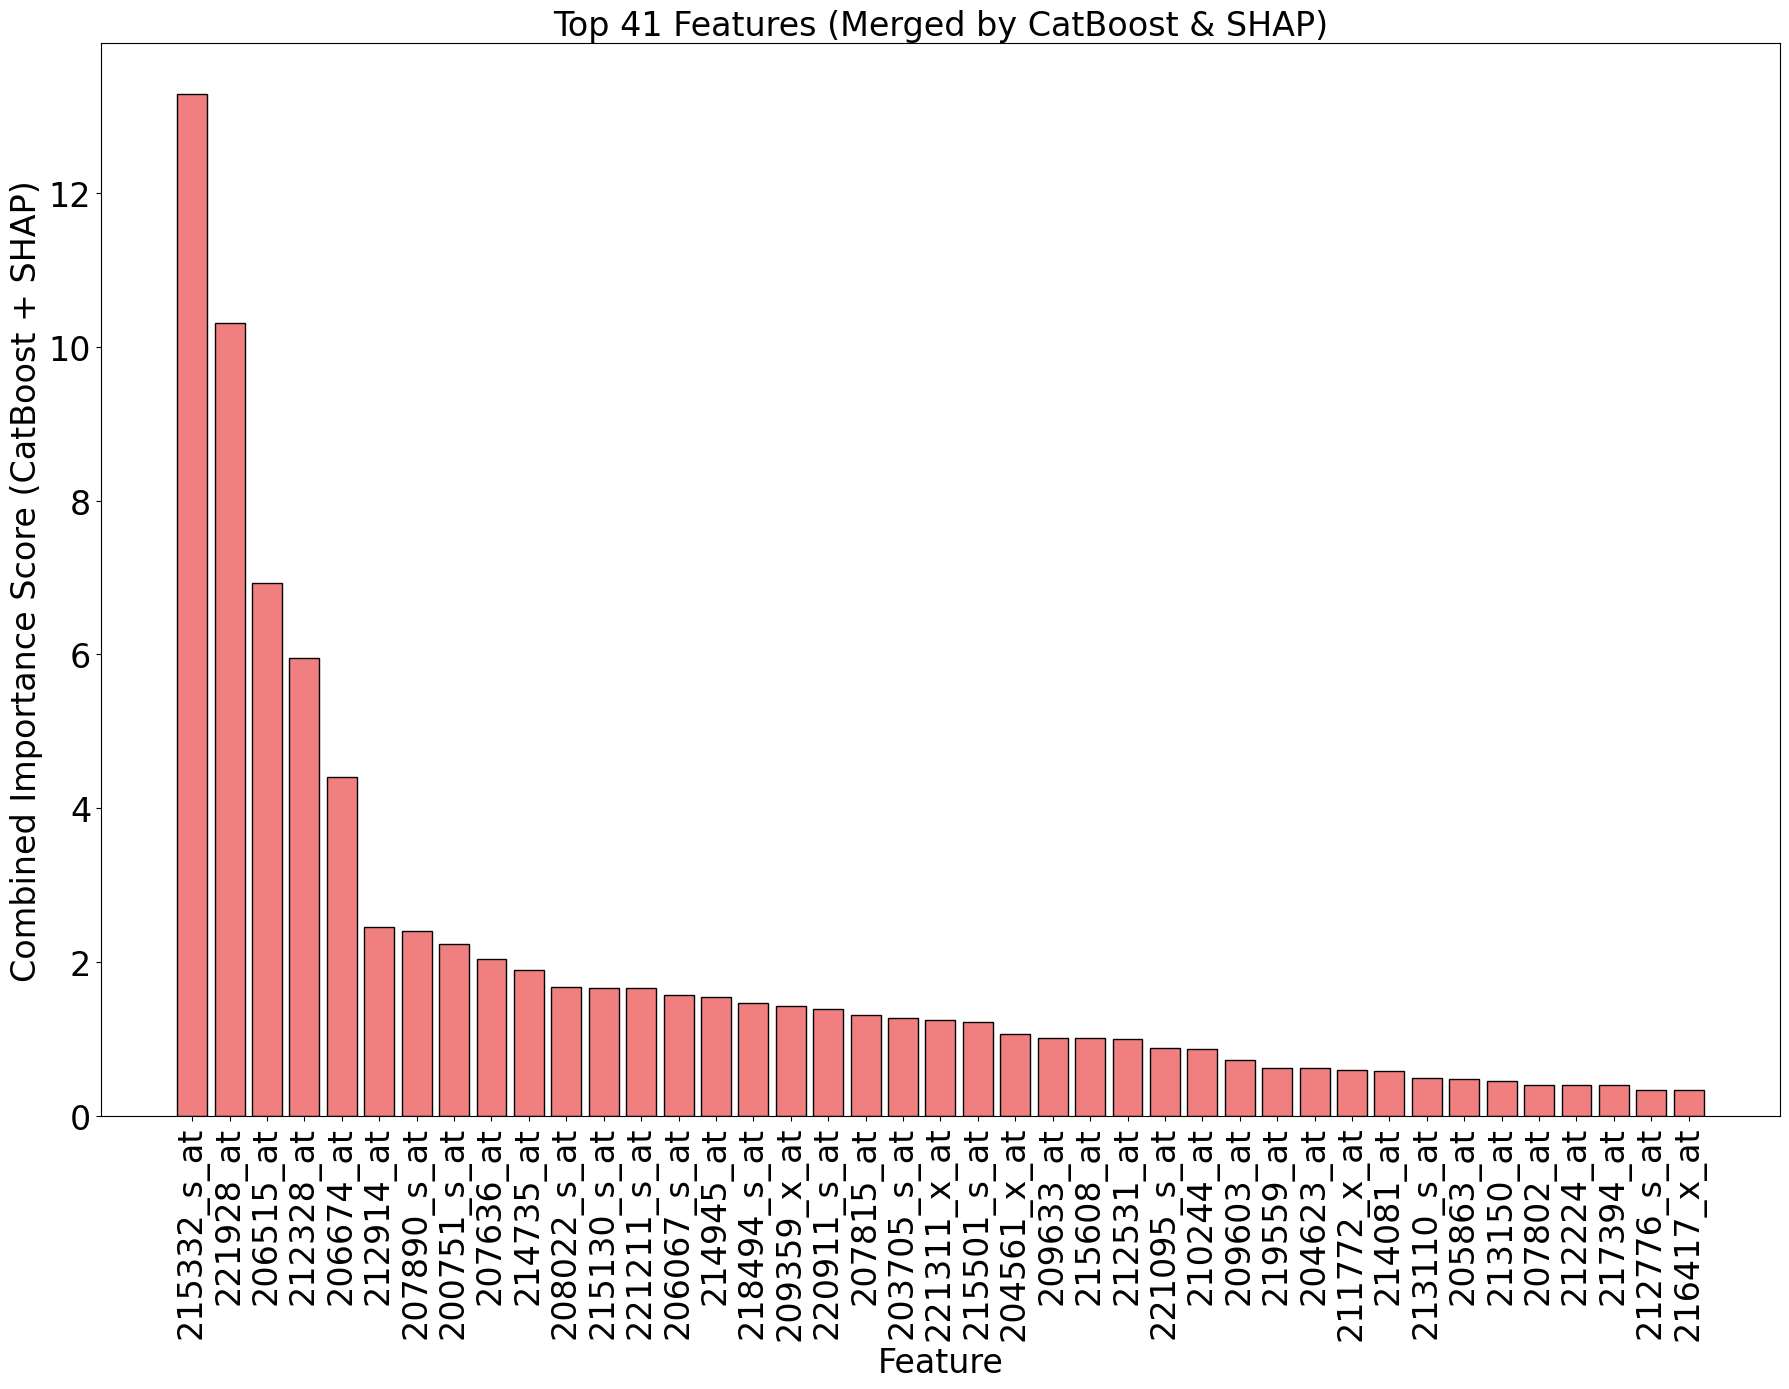

2025-07-09 11:30:52,970 - INFO - Training CNN Ensemble...
2025-07-09 11:30:53,066 - INFO - Fitting CNN Models...
2025-07-09 11:33:10,324 - INFO - CNN Ensemble trained in 137.26 seconds.
2025-07-09 11:33:10,330 - INFO - Predicting with CNN Models...
2025-07-09 11:33:12,018 - INFO - CNN Ensemble predicted in 1.69 seconds.
2025-07-09 11:33:12,021 - INFO - Calculating Evaluation Metrics...
2025-07-09 11:33:12,029 - INFO - Evaluation metrics: {'accuracy': 0.994535519125683, 'precision': 0.9975216852540273, 'recall': 0.9906103286384976, 'f1_score': 0.9939943141435679, 'confusion_matrix': [[69, 2, 0], [0, 267, 0], [0, 0, 28]]}


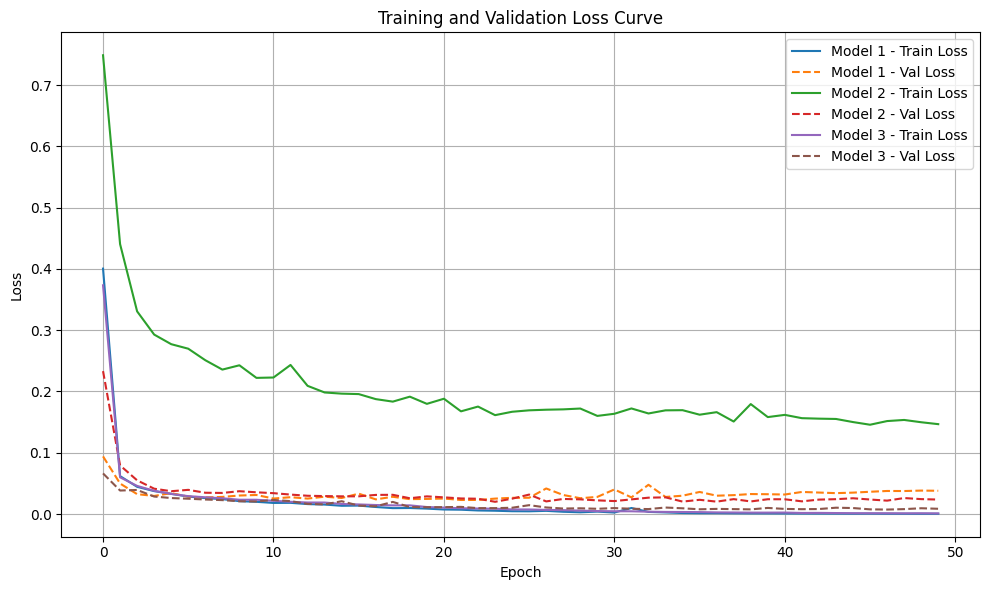

2025-07-09 11:33:12,443 - INFO - Cleaning up models...
2025-07-09 11:33:13,841 - INFO - Fold 5/10
2025-07-09 11:33:18,081 - INFO - Starting dimensionality reduction...


0:	learn: 0.9262807	total: 488ms	remaining: 1m 37s
1:	learn: 0.7954415	total: 659ms	remaining: 1m 5s
2:	learn: 0.6921552	total: 845ms	remaining: 55.5s
3:	learn: 0.6084091	total: 1.02s	remaining: 49.8s
4:	learn: 0.5371224	total: 1.21s	remaining: 47.1s
5:	learn: 0.4780818	total: 1.4s	remaining: 45.1s
6:	learn: 0.4273092	total: 1.59s	remaining: 43.9s
7:	learn: 0.3833812	total: 1.77s	remaining: 42.5s
8:	learn: 0.3452935	total: 1.95s	remaining: 41.4s
9:	learn: 0.3121671	total: 2.14s	remaining: 40.7s
10:	learn: 0.2825775	total: 2.33s	remaining: 40.1s
11:	learn: 0.2568230	total: 2.52s	remaining: 39.4s
12:	learn: 0.2339457	total: 2.7s	remaining: 38.8s
13:	learn: 0.2134559	total: 2.87s	remaining: 38.1s
14:	learn: 0.1954897	total: 3.05s	remaining: 37.7s
15:	learn: 0.1792462	total: 3.21s	remaining: 37s
16:	learn: 0.1648549	total: 3.41s	remaining: 36.7s
17:	learn: 0.1519941	total: 3.59s	remaining: 36.3s
18:	learn: 0.1401852	total: 3.78s	remaining: 36s
19:	learn: 0.1296947	total: 3.96s	remaining: 3

2025-07-09 11:34:02,814 - INFO - Calculating SHAP values...
2025-07-09 11:35:01,026 - INFO - SHAP values: Multiclass (3D Array), Shape: (3289, 22277, 3)
2025-07-09 11:35:03,850 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 11:35:03,865 - INFO - Shape of shap_importance: (22277,)
2025-07-09 11:35:03,865 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 11:35:03,865 - INFO - Shape of X.columns: (22277,)
2025-07-09 11:35:03,865 - INFO - Length comparison: len(X.columns)=22277, len(shap_importance)=22277
2025-07-09 11:35:03,881 - INFO - SHAP values calculated.
2025-07-09 11:35:03,881 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_4.pkl
2025-07-09 11:35:03,897 - INFO - Dimensionality reduction completed in 105.82 seconds.


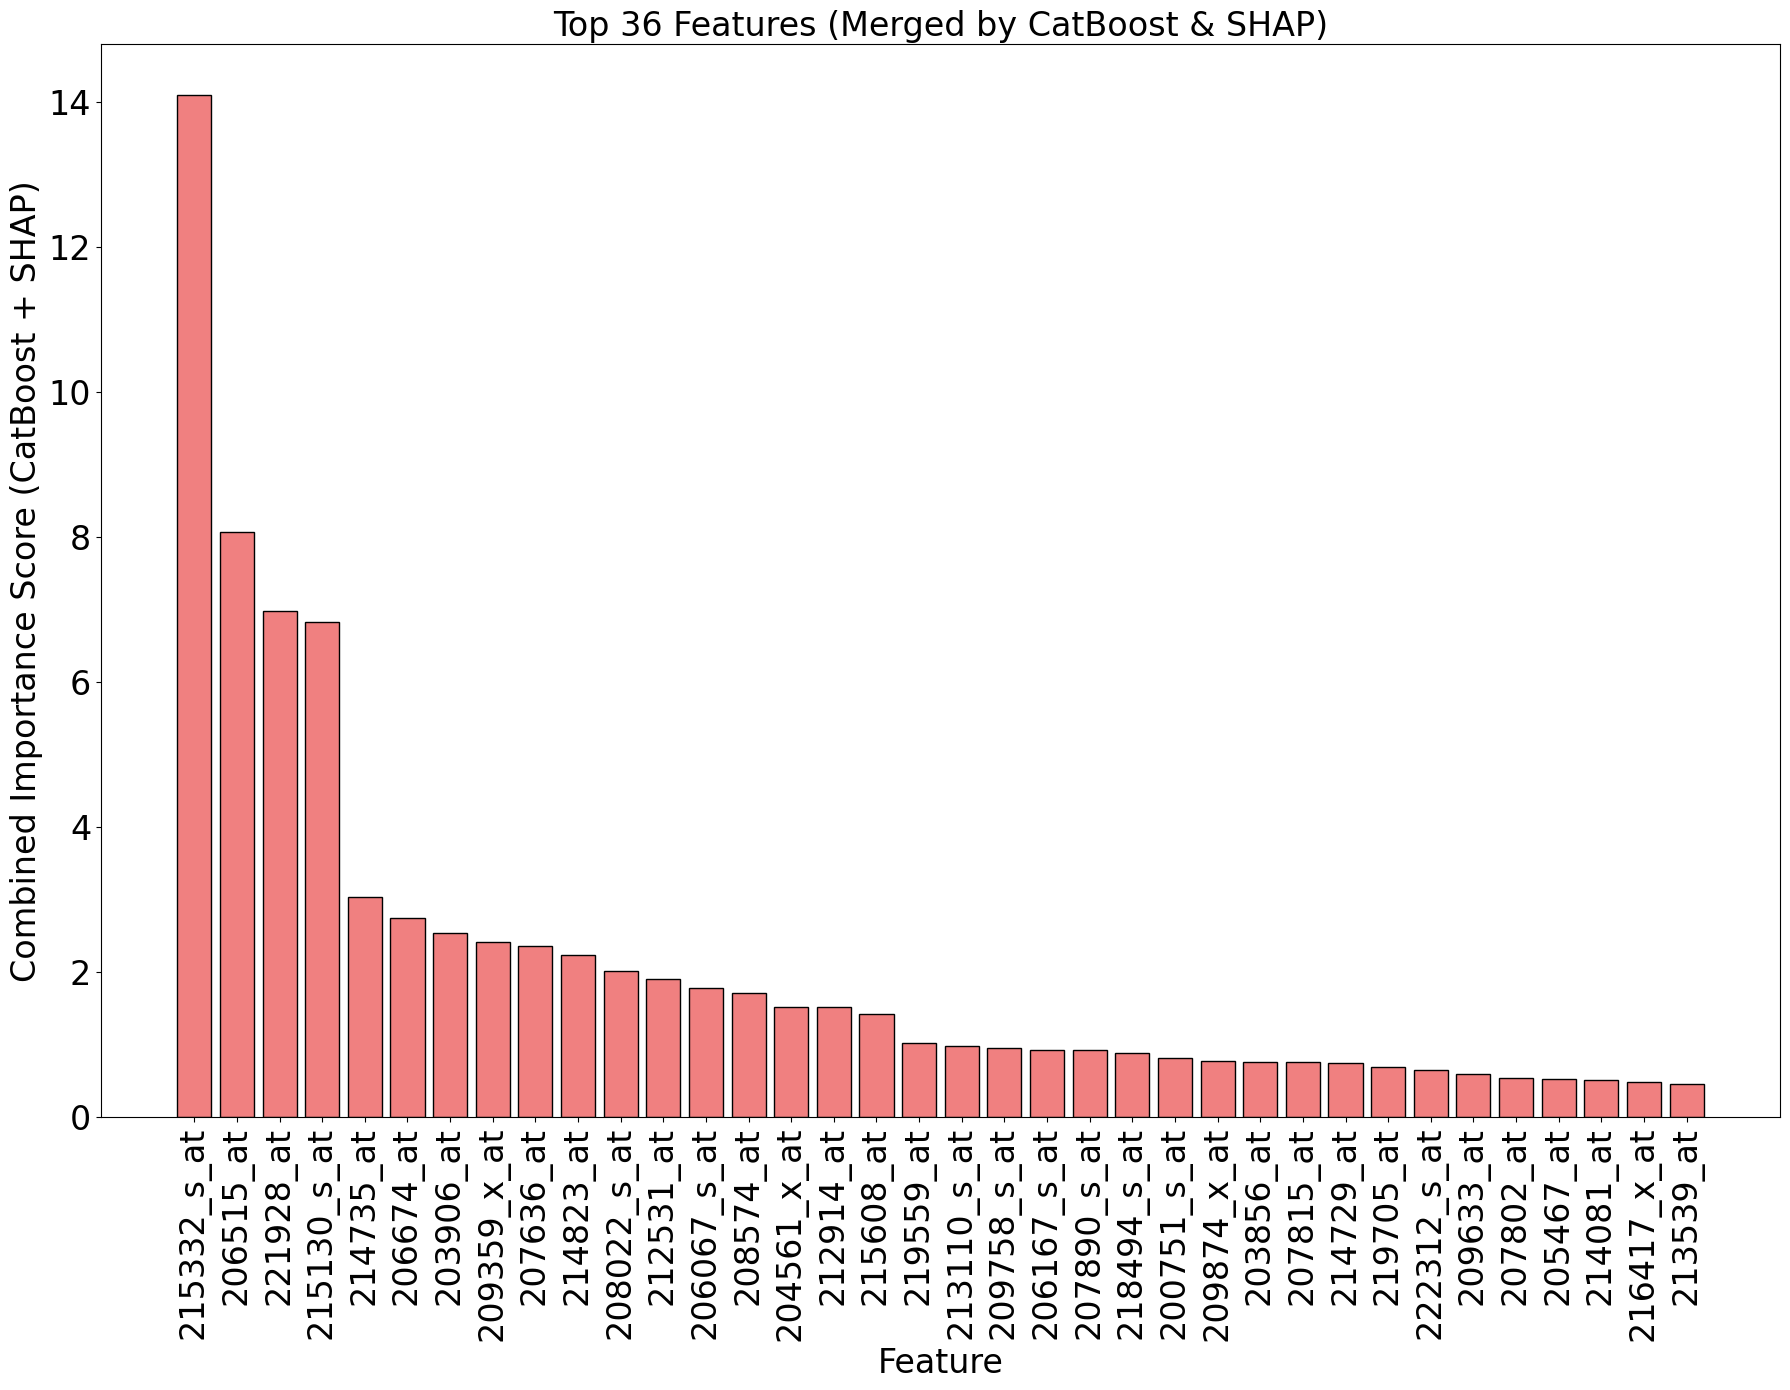

2025-07-09 11:35:05,368 - INFO - Training CNN Ensemble...
2025-07-09 11:35:05,604 - INFO - Fitting CNN Models...
2025-07-09 11:38:20,678 - INFO - CNN Ensemble trained in 195.07 seconds.
2025-07-09 11:38:20,680 - INFO - Predicting with CNN Models...
2025-07-09 11:38:22,558 - INFO - CNN Ensemble predicted in 1.88 seconds.
2025-07-09 11:38:22,558 - INFO - Calculating Evaluation Metrics...
2025-07-09 11:38:22,590 - INFO - Evaluation metrics: {'accuracy': 0.9972677595628415, 'precision': 0.9953703703703703, 'recall': 0.9987515605493135, 'f1_score': 0.9970436067997044, 'confusion_matrix': [[71, 0, 0], [1, 266, 0], [0, 0, 28]]}


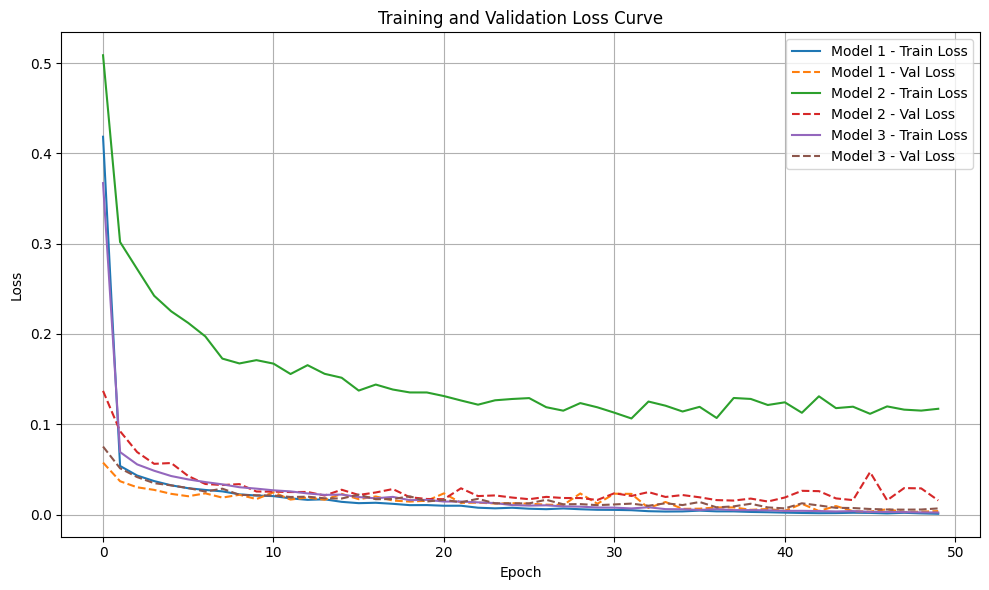

2025-07-09 11:38:23,003 - INFO - Cleaning up models...
2025-07-09 11:38:24,570 - INFO - Fold 6/10
2025-07-09 11:38:29,451 - INFO - Starting dimensionality reduction...


0:	learn: 0.9285717	total: 532ms	remaining: 1m 45s
1:	learn: 0.7986642	total: 739ms	remaining: 1m 13s
2:	learn: 0.6940300	total: 944ms	remaining: 1m 1s
3:	learn: 0.6099150	total: 1.13s	remaining: 55.5s
4:	learn: 0.5395713	total: 1.33s	remaining: 51.9s
5:	learn: 0.4803393	total: 1.52s	remaining: 49.2s
6:	learn: 0.4290310	total: 1.71s	remaining: 47.2s
7:	learn: 0.3847408	total: 1.9s	remaining: 45.5s
8:	learn: 0.3467381	total: 2.1s	remaining: 44.6s
9:	learn: 0.3136929	total: 2.3s	remaining: 43.7s
10:	learn: 0.2837384	total: 2.5s	remaining: 43s
11:	learn: 0.2574953	total: 2.7s	remaining: 42.3s
12:	learn: 0.2346592	total: 2.9s	remaining: 41.7s
13:	learn: 0.2147113	total: 3.1s	remaining: 41.2s
14:	learn: 0.1966480	total: 3.27s	remaining: 40.4s
15:	learn: 0.1805512	total: 3.47s	remaining: 39.9s
16:	learn: 0.1658850	total: 3.65s	remaining: 39.2s
17:	learn: 0.1525673	total: 3.85s	remaining: 38.9s
18:	learn: 0.1406724	total: 4.03s	remaining: 38.4s
19:	learn: 0.1302025	total: 4.22s	remaining: 38s

2025-07-09 11:39:16,073 - INFO - Calculating SHAP values...
2025-07-09 11:40:12,720 - INFO - SHAP values: Multiclass (3D Array), Shape: (3290, 22277, 3)
2025-07-09 11:40:15,590 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 11:40:15,590 - INFO - Shape of shap_importance: (22277,)
2025-07-09 11:40:15,590 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 11:40:15,606 - INFO - Shape of X.columns: (22277,)
2025-07-09 11:40:15,606 - INFO - Length comparison: len(X.columns)=22277, len(shap_importance)=22277
2025-07-09 11:40:15,622 - INFO - SHAP values calculated.
2025-07-09 11:40:15,638 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_5.pkl
2025-07-09 11:40:15,638 - INFO - Dimensionality reduction completed in 106.19 seconds.


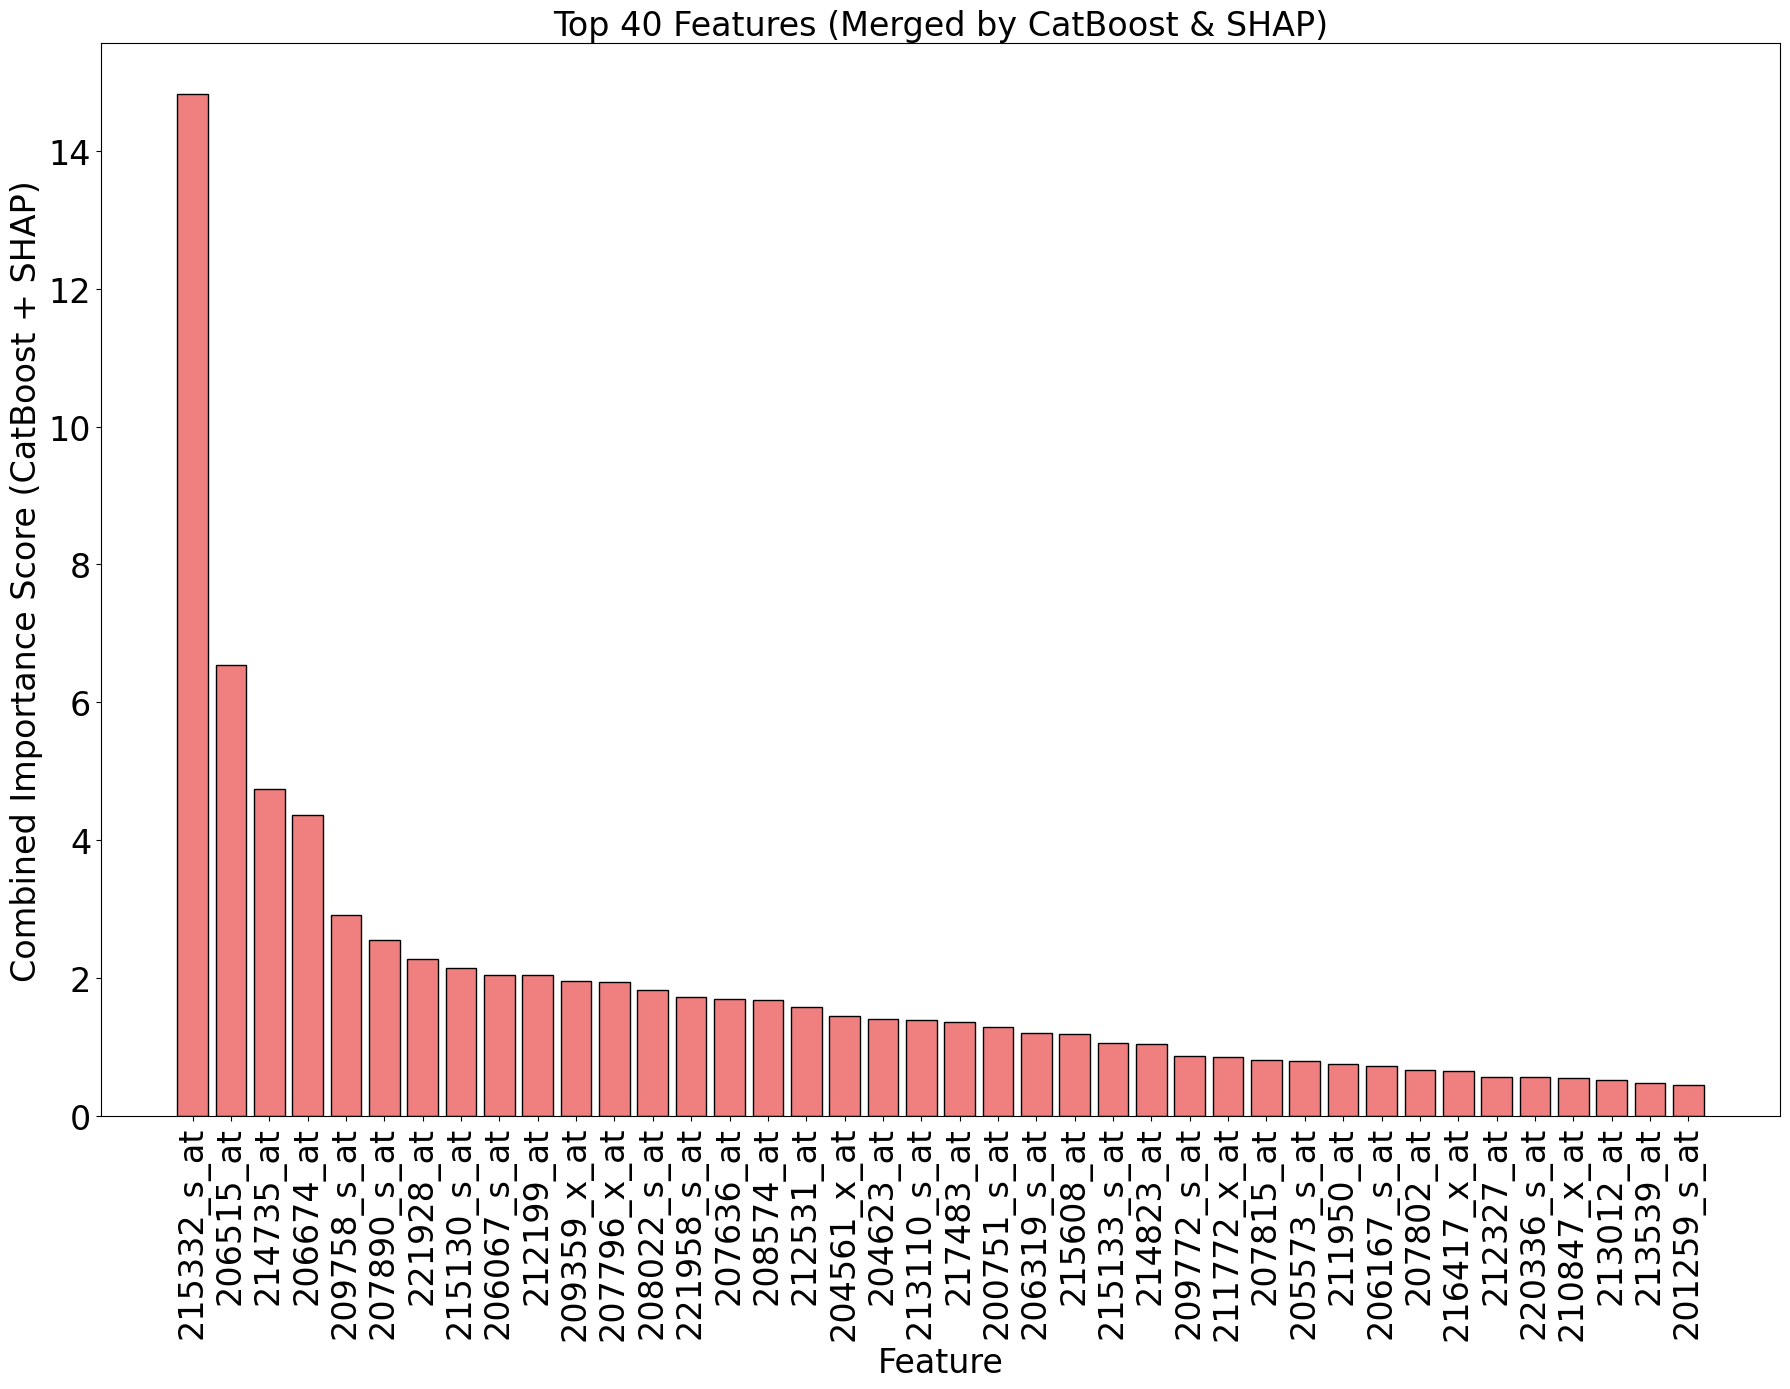

2025-07-09 11:40:17,429 - INFO - Training CNN Ensemble...
2025-07-09 11:40:17,679 - INFO - Fitting CNN Models...
2025-07-09 11:42:58,104 - INFO - CNN Ensemble trained in 160.42 seconds.
2025-07-09 11:42:58,104 - INFO - Predicting with CNN Models...
2025-07-09 11:42:59,373 - INFO - CNN Ensemble predicted in 1.27 seconds.
2025-07-09 11:42:59,373 - INFO - Calculating Evaluation Metrics...
2025-07-09 11:42:59,389 - INFO - Evaluation metrics: {'accuracy': 0.9945205479452055, 'precision': 0.9907407407407408, 'recall': 0.9975031210986267, 'f1_score': 0.9940520314871687, 'confusion_matrix': [[70, 0, 0], [2, 265, 0], [0, 0, 28]]}


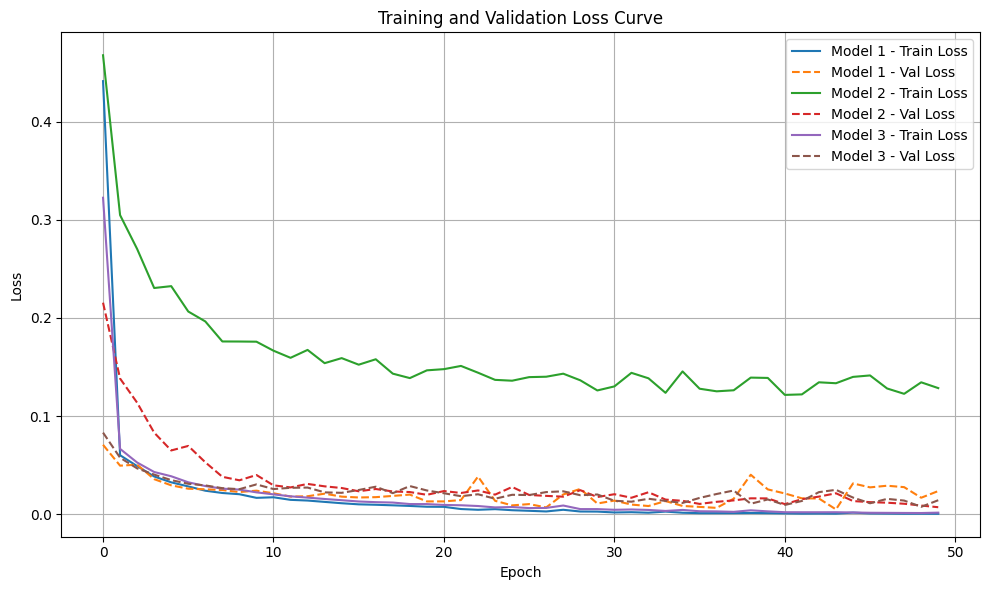

2025-07-09 11:42:59,708 - INFO - Cleaning up models...
2025-07-09 11:43:00,869 - INFO - Fold 7/10
2025-07-09 11:43:04,210 - INFO - Starting dimensionality reduction...


0:	learn: 0.9257522	total: 605ms	remaining: 2m
1:	learn: 0.7945847	total: 780ms	remaining: 1m 17s
2:	learn: 0.6905455	total: 952ms	remaining: 1m 2s
3:	learn: 0.6058473	total: 1.14s	remaining: 55.8s
4:	learn: 0.5357417	total: 1.31s	remaining: 51.2s
5:	learn: 0.4763644	total: 1.49s	remaining: 48.2s
6:	learn: 0.4253049	total: 1.67s	remaining: 46.1s
7:	learn: 0.3807152	total: 1.85s	remaining: 44.5s
8:	learn: 0.3432619	total: 2.04s	remaining: 43.2s
9:	learn: 0.3103940	total: 2.22s	remaining: 42.2s
10:	learn: 0.2808092	total: 2.4s	remaining: 41.3s
11:	learn: 0.2549748	total: 2.58s	remaining: 40.3s
12:	learn: 0.2325557	total: 2.76s	remaining: 39.6s
13:	learn: 0.2121143	total: 2.91s	remaining: 38.7s
14:	learn: 0.1939033	total: 3.08s	remaining: 38s
15:	learn: 0.1775808	total: 3.26s	remaining: 37.5s
16:	learn: 0.1633469	total: 3.43s	remaining: 36.9s
17:	learn: 0.1505306	total: 3.59s	remaining: 36.3s
18:	learn: 0.1390028	total: 3.77s	remaining: 35.9s
19:	learn: 0.1287090	total: 3.95s	remaining: 3

2025-07-09 11:43:45,877 - INFO - Calculating SHAP values...
2025-07-09 11:44:34,375 - INFO - SHAP values: Multiclass (3D Array), Shape: (3290, 22277, 3)
2025-07-09 11:44:36,630 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 11:44:36,630 - INFO - Shape of shap_importance: (22277,)
2025-07-09 11:44:36,630 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 11:44:36,630 - INFO - Shape of X.columns: (22277,)
2025-07-09 11:44:36,630 - INFO - Length comparison: len(X.columns)=22277, len(shap_importance)=22277
2025-07-09 11:44:36,645 - INFO - SHAP values calculated.
2025-07-09 11:44:36,645 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_6.pkl
2025-07-09 11:44:36,645 - INFO - Dimensionality reduction completed in 92.44 seconds.


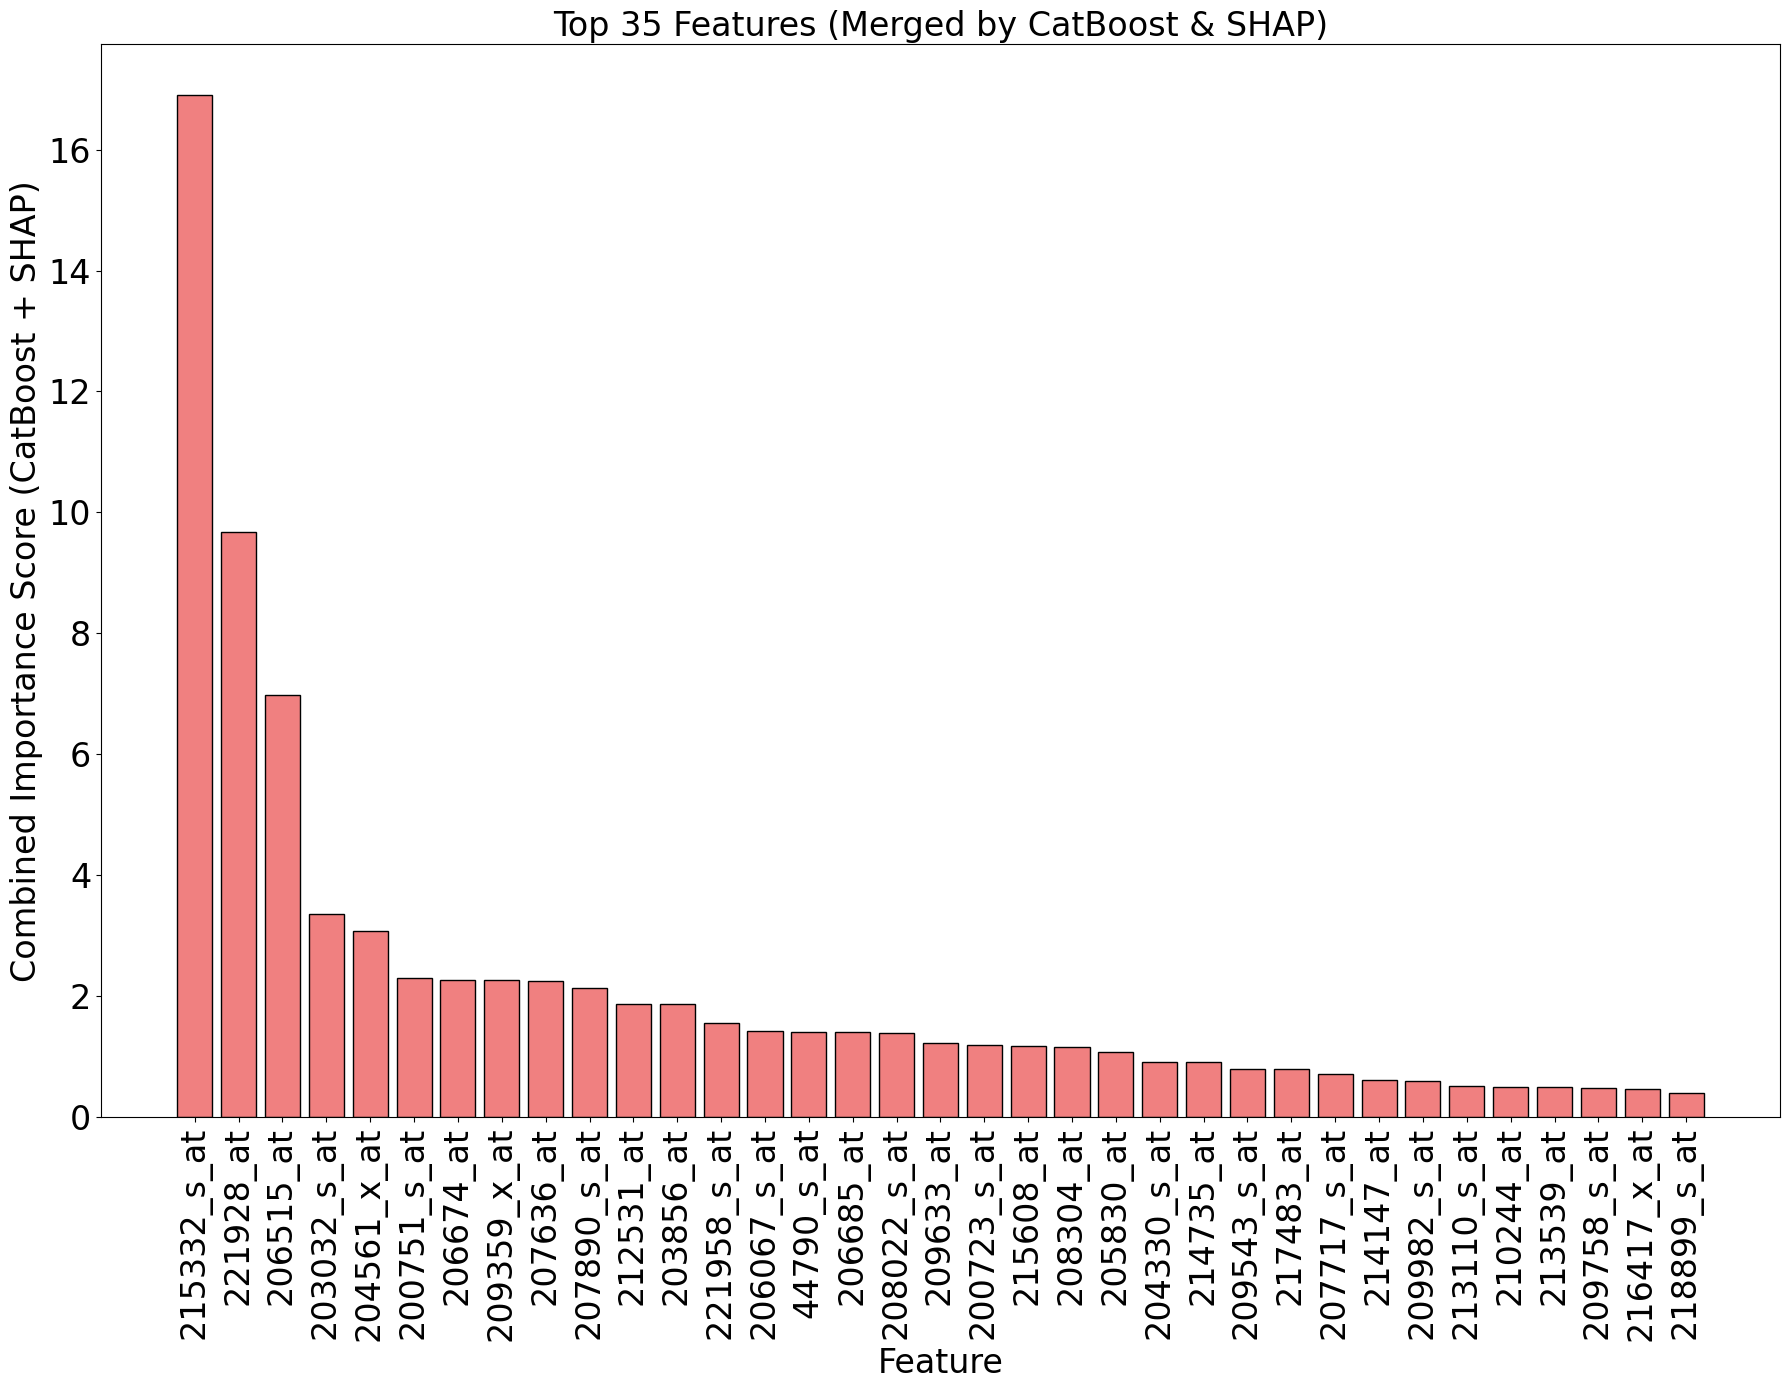

2025-07-09 11:44:37,796 - INFO - Training CNN Ensemble...
2025-07-09 11:44:37,984 - INFO - Fitting CNN Models...
2025-07-09 11:47:48,544 - INFO - CNN Ensemble trained in 190.56 seconds.
2025-07-09 11:47:48,546 - INFO - Predicting with CNN Models...
2025-07-09 11:47:50,043 - INFO - CNN Ensemble predicted in 1.50 seconds.
2025-07-09 11:47:50,043 - INFO - Calculating Evaluation Metrics...
2025-07-09 11:47:50,062 - INFO - Evaluation metrics: {'accuracy': 0.9972602739726028, 'precision': 0.9987562189054726, 'recall': 0.9952380952380953, 'f1_score': 0.9969788655057262, 'confusion_matrix': [[69, 1, 0], [0, 267, 0], [0, 0, 28]]}


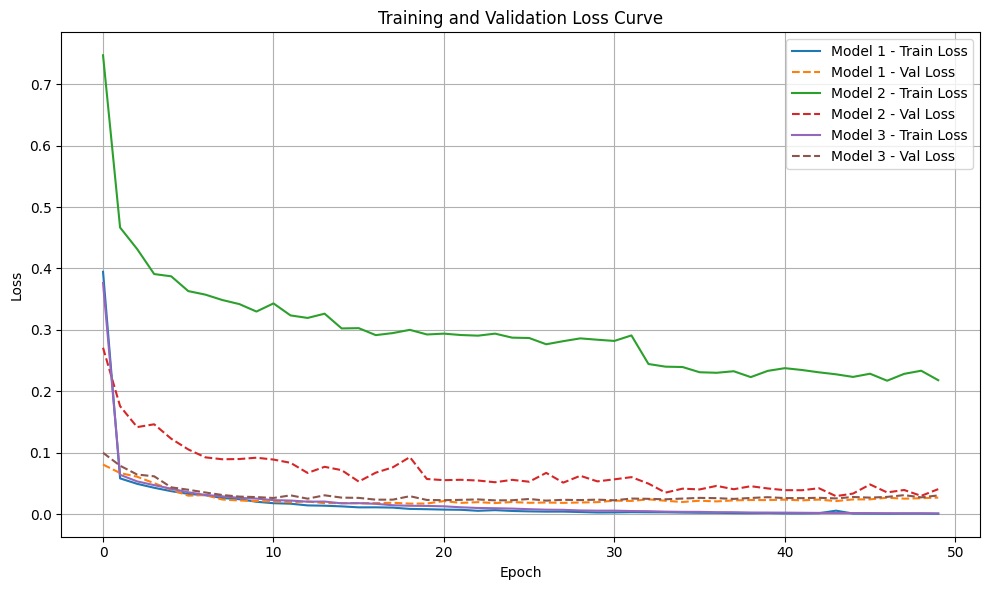

2025-07-09 11:47:50,440 - INFO - Cleaning up models...
2025-07-09 11:47:51,680 - INFO - Fold 8/10
2025-07-09 11:47:54,949 - INFO - Starting dimensionality reduction...


0:	learn: 0.9256089	total: 464ms	remaining: 1m 32s
1:	learn: 0.7950575	total: 641ms	remaining: 1m 3s
2:	learn: 0.6913887	total: 810ms	remaining: 53.2s
3:	learn: 0.6067541	total: 990ms	remaining: 48.5s
4:	learn: 0.5372609	total: 1.17s	remaining: 45.8s
5:	learn: 0.4780893	total: 1.36s	remaining: 43.9s
6:	learn: 0.4263262	total: 1.53s	remaining: 42.1s
7:	learn: 0.3829079	total: 1.71s	remaining: 40.9s
8:	learn: 0.3450790	total: 1.89s	remaining: 40.1s
9:	learn: 0.3120124	total: 2.07s	remaining: 39.4s
10:	learn: 0.2827598	total: 2.23s	remaining: 38.4s
11:	learn: 0.2565968	total: 2.42s	remaining: 37.8s
12:	learn: 0.2337018	total: 2.58s	remaining: 37.1s
13:	learn: 0.2135141	total: 2.76s	remaining: 36.6s
14:	learn: 0.1953586	total: 2.92s	remaining: 36.1s
15:	learn: 0.1795995	total: 3.11s	remaining: 35.7s
16:	learn: 0.1649886	total: 3.28s	remaining: 35.4s
17:	learn: 0.1515543	total: 3.46s	remaining: 34.9s
18:	learn: 0.1399390	total: 3.63s	remaining: 34.6s
19:	learn: 0.1294531	total: 3.81s	remain

2025-07-09 11:48:37,242 - INFO - Calculating SHAP values...
2025-07-09 11:49:28,875 - INFO - SHAP values: Multiclass (3D Array), Shape: (3290, 22277, 3)
2025-07-09 11:49:31,247 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 11:49:31,249 - INFO - Shape of shap_importance: (22277,)
2025-07-09 11:49:31,250 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 11:49:31,250 - INFO - Shape of X.columns: (22277,)
2025-07-09 11:49:31,250 - INFO - Length comparison: len(X.columns)=22277, len(shap_importance)=22277
2025-07-09 11:49:31,250 - INFO - SHAP values calculated.
2025-07-09 11:49:31,273 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_7.pkl
2025-07-09 11:49:31,275 - INFO - Dimensionality reduction completed in 96.33 seconds.


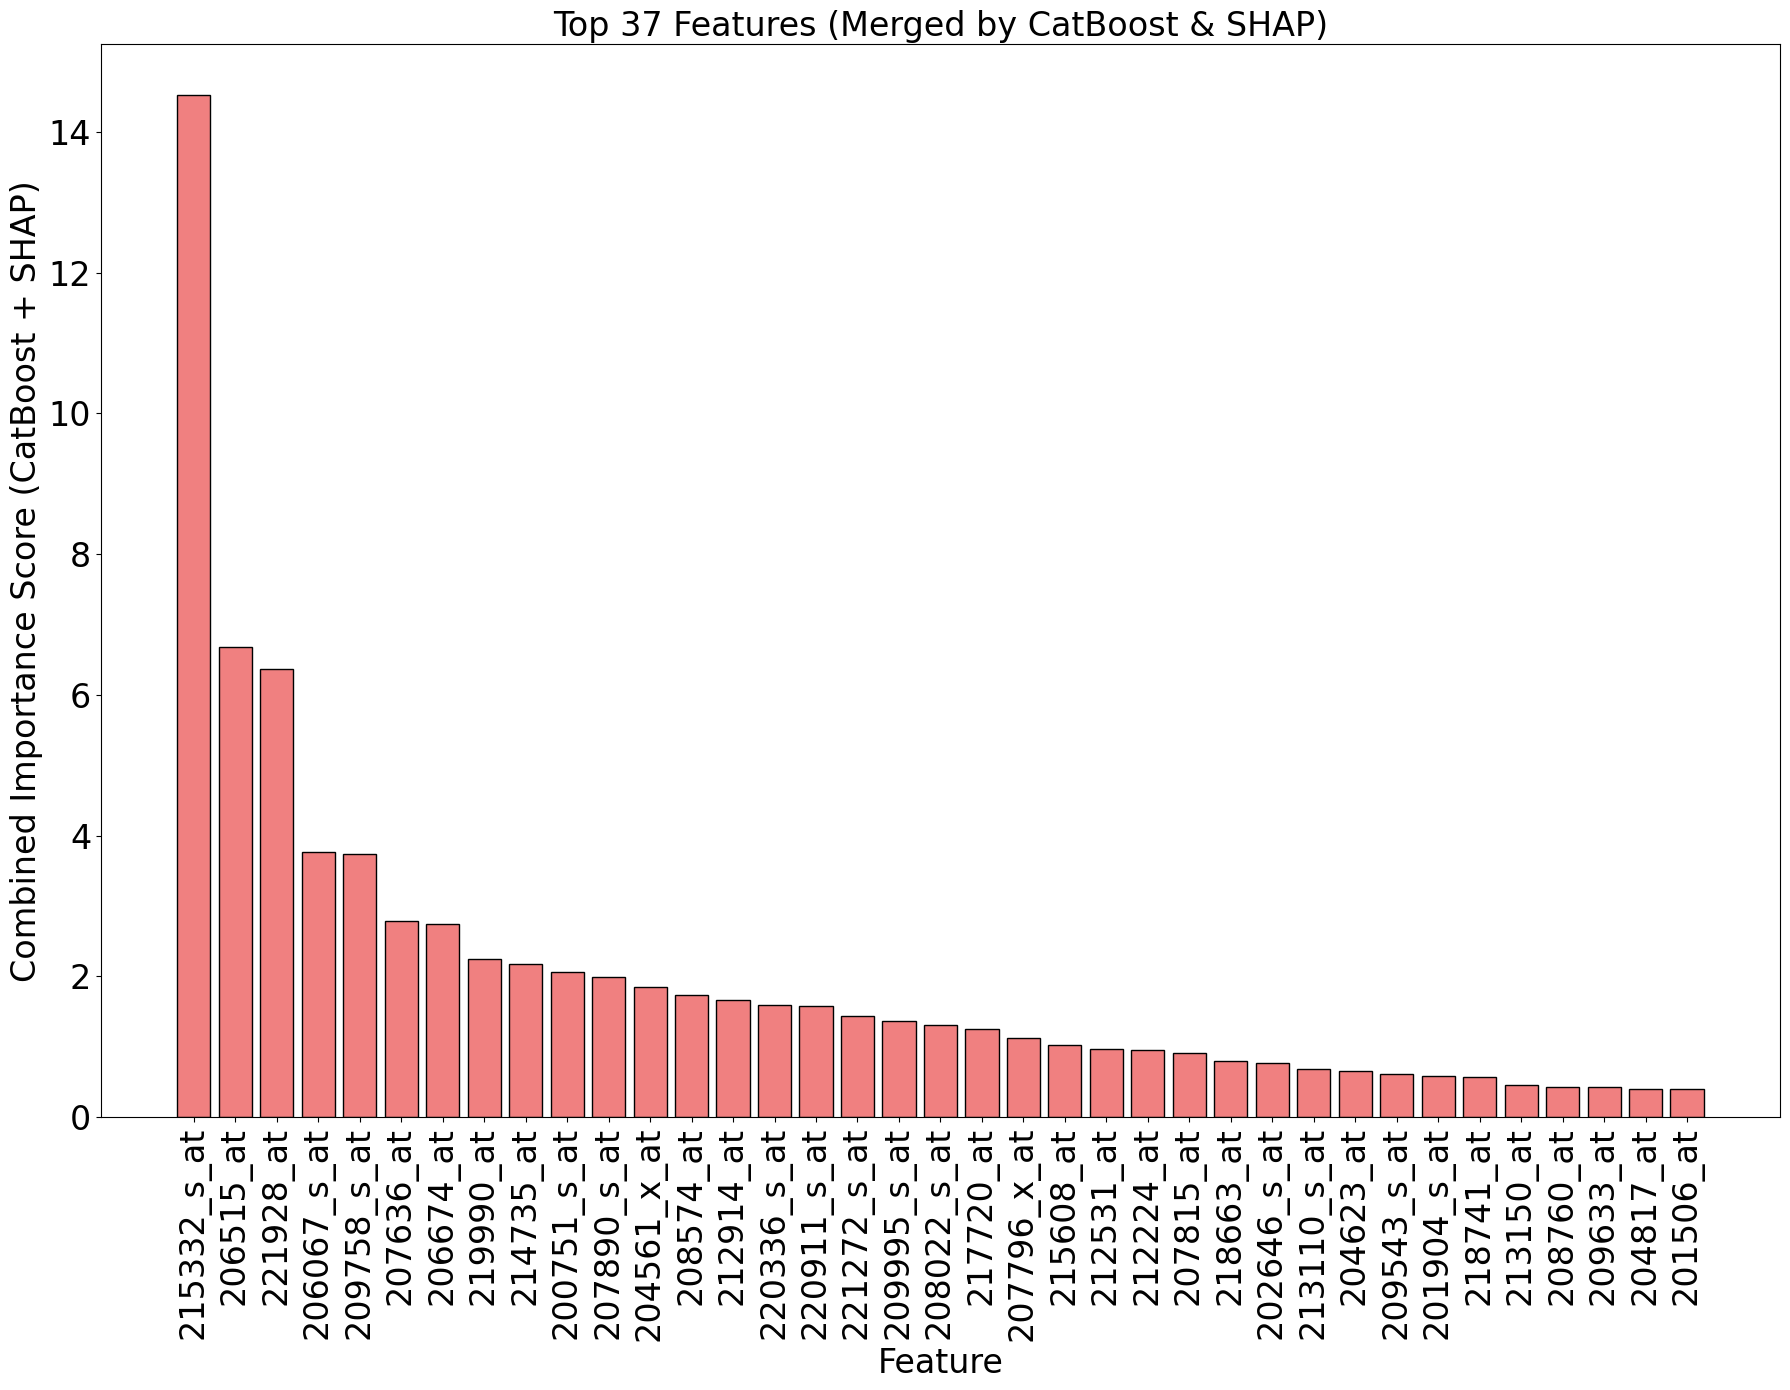

2025-07-09 11:49:32,514 - INFO - Training CNN Ensemble...
2025-07-09 11:49:32,675 - INFO - Fitting CNN Models...
2025-07-09 11:52:30,330 - INFO - CNN Ensemble trained in 177.66 seconds.
2025-07-09 11:52:30,330 - INFO - Predicting with CNN Models...
2025-07-09 11:52:30,925 - INFO - CNN Ensemble predicted in 0.59 seconds.
2025-07-09 11:52:30,925 - INFO - Calculating Evaluation Metrics...
2025-07-09 11:52:30,931 - INFO - Evaluation metrics: {'accuracy': 0.9945205479452055, 'precision': 0.9939896557874087, 'recall': 0.9939896557874087, 'f1_score': 0.9939896557874087, 'confusion_matrix': [[69, 1, 0], [1, 266, 0], [0, 0, 28]]}


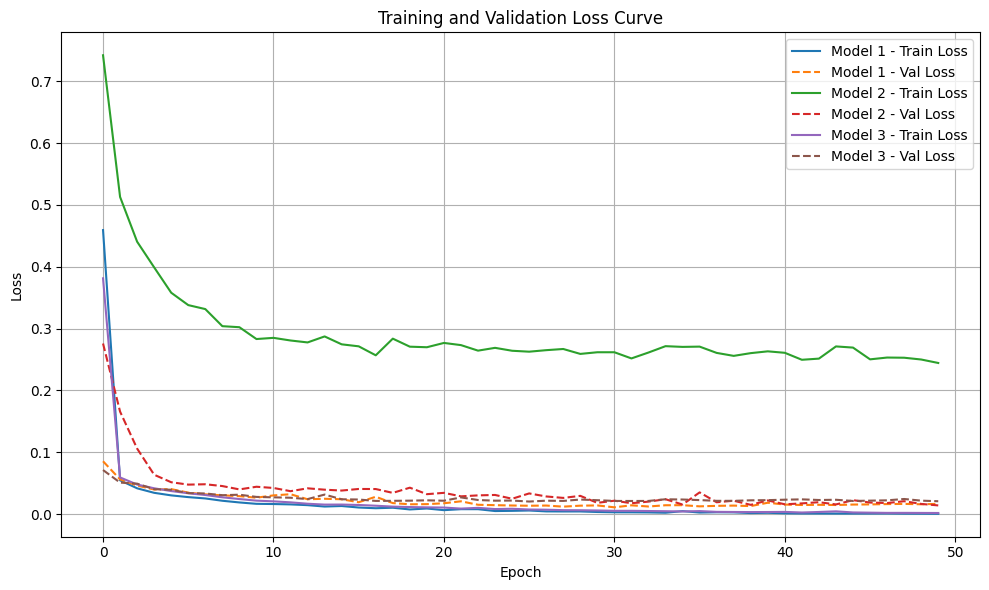

2025-07-09 11:52:31,109 - INFO - Cleaning up models...
2025-07-09 11:52:32,173 - INFO - Fold 9/10
2025-07-09 11:52:34,002 - INFO - Starting dimensionality reduction...


0:	learn: 0.9257463	total: 589ms	remaining: 1m 57s
1:	learn: 0.7949728	total: 775ms	remaining: 1m 16s
2:	learn: 0.6910009	total: 939ms	remaining: 1m 1s
3:	learn: 0.6067542	total: 1.11s	remaining: 54.4s
4:	learn: 0.5364058	total: 1.28s	remaining: 50.1s
5:	learn: 0.4765964	total: 1.46s	remaining: 47.1s
6:	learn: 0.4256011	total: 1.63s	remaining: 44.9s
7:	learn: 0.3822363	total: 1.8s	remaining: 43.3s
8:	learn: 0.3433438	total: 1.97s	remaining: 41.7s
9:	learn: 0.3109747	total: 2.14s	remaining: 40.6s
10:	learn: 0.2816187	total: 2.31s	remaining: 39.8s
11:	learn: 0.2557654	total: 2.49s	remaining: 39s
12:	learn: 0.2329290	total: 2.67s	remaining: 38.4s
13:	learn: 0.2126667	total: 2.84s	remaining: 37.7s
14:	learn: 0.1943485	total: 3.01s	remaining: 37.1s
15:	learn: 0.1782795	total: 3.19s	remaining: 36.7s
16:	learn: 0.1636567	total: 3.36s	remaining: 36.1s
17:	learn: 0.1503494	total: 3.53s	remaining: 35.7s
18:	learn: 0.1384064	total: 3.69s	remaining: 35.2s
19:	learn: 0.1276421	total: 3.87s	remainin

2025-07-09 11:53:16,285 - INFO - Calculating SHAP values...
2025-07-09 11:54:05,785 - INFO - SHAP values: Multiclass (3D Array), Shape: (3290, 22277, 3)
2025-07-09 11:54:08,089 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 11:54:08,089 - INFO - Shape of shap_importance: (22277,)
2025-07-09 11:54:08,089 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 11:54:08,089 - INFO - Shape of X.columns: (22277,)
2025-07-09 11:54:08,089 - INFO - Length comparison: len(X.columns)=22277, len(shap_importance)=22277
2025-07-09 11:54:08,105 - INFO - SHAP values calculated.
2025-07-09 11:54:08,105 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_8.pkl
2025-07-09 11:54:08,105 - INFO - Dimensionality reduction completed in 94.10 seconds.


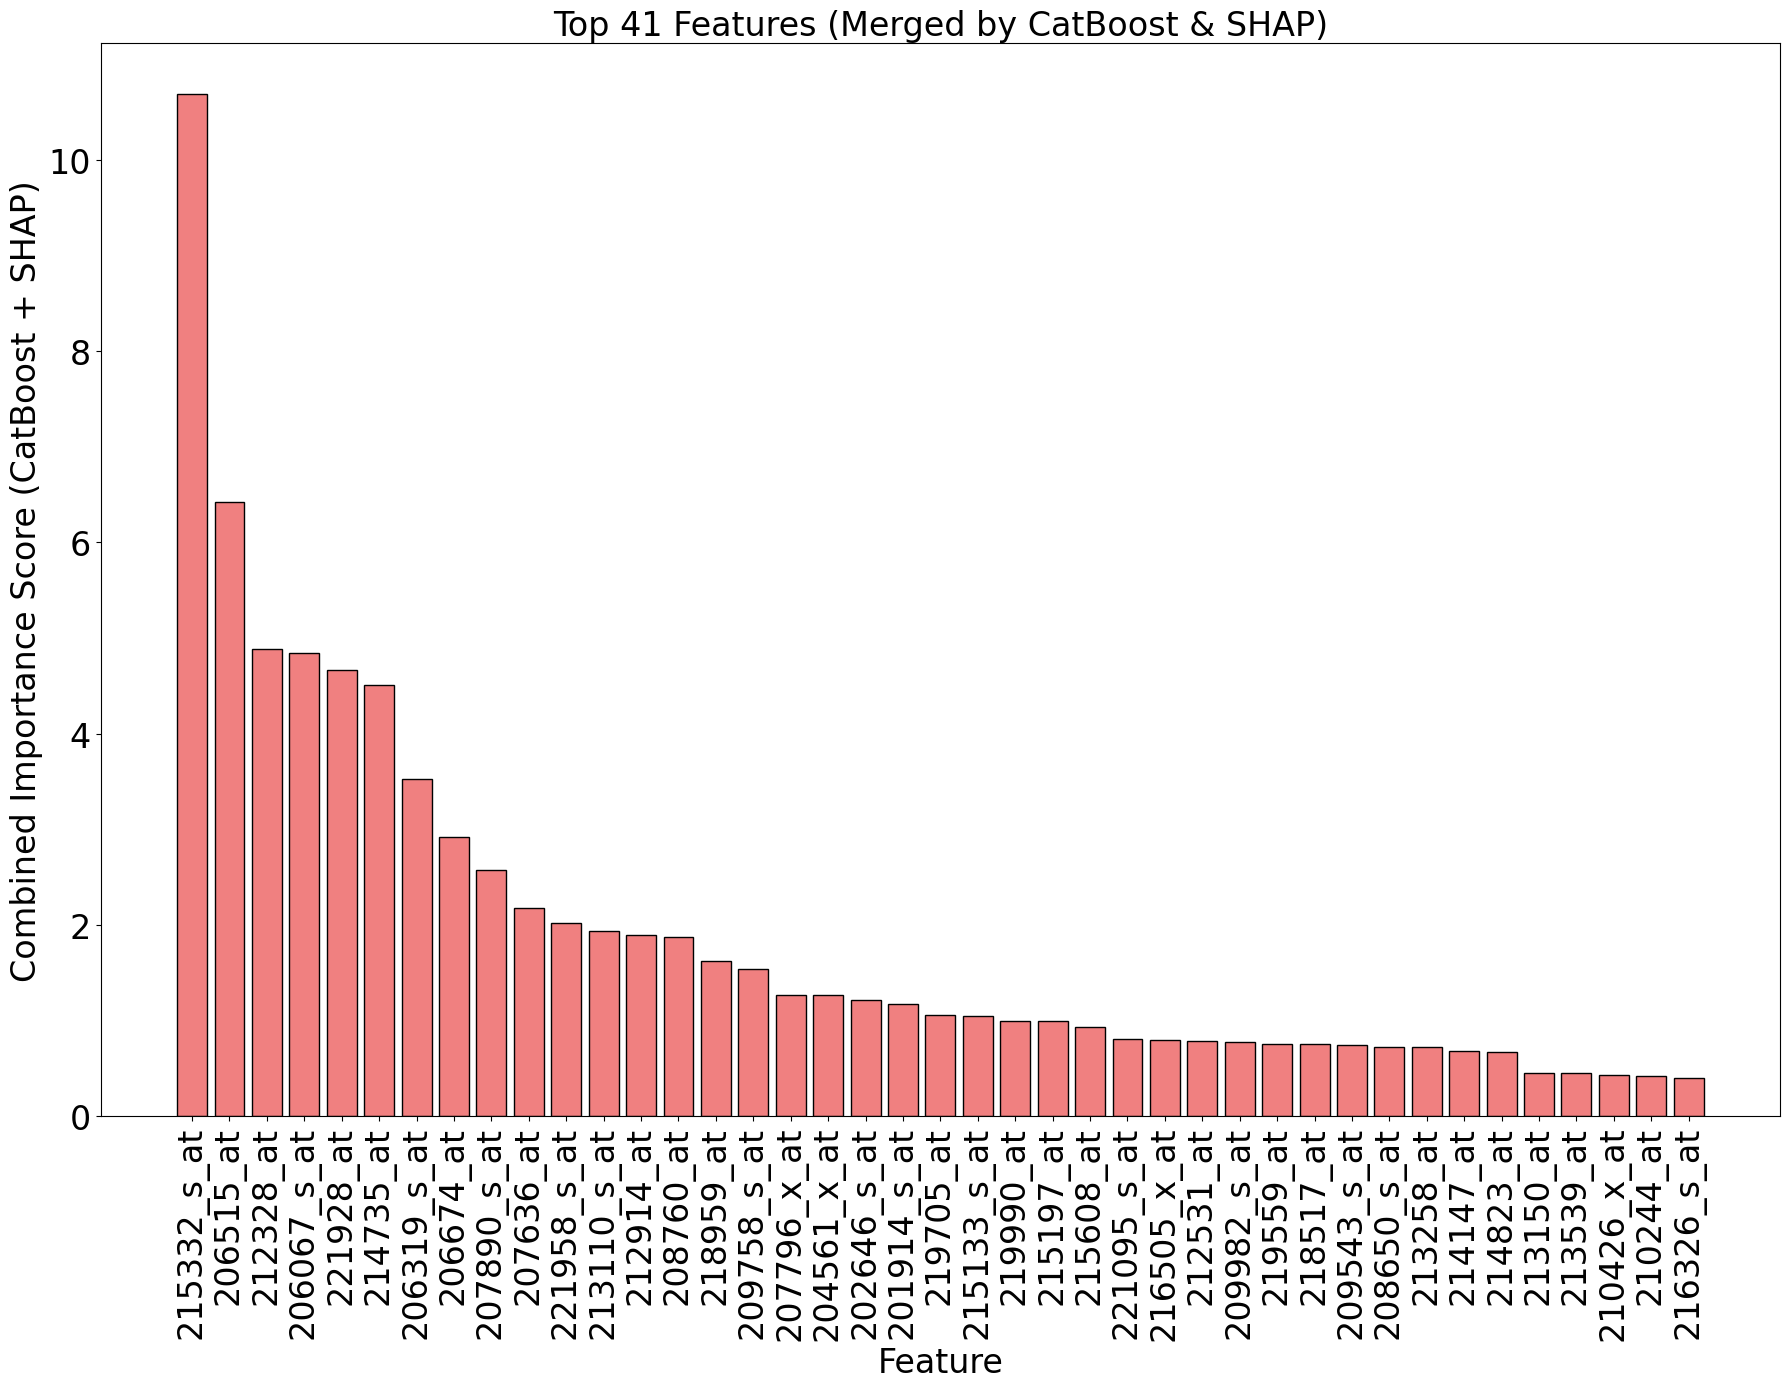

2025-07-09 11:54:09,257 - INFO - Training CNN Ensemble...
2025-07-09 11:54:09,452 - INFO - Fitting CNN Models...
2025-07-09 11:57:18,505 - INFO - CNN Ensemble trained in 189.05 seconds.
2025-07-09 11:57:18,521 - INFO - Predicting with CNN Models...
2025-07-09 11:57:19,762 - INFO - CNN Ensemble predicted in 1.24 seconds.
2025-07-09 11:57:19,763 - INFO - Calculating Evaluation Metrics...
2025-07-09 11:57:19,778 - INFO - Evaluation metrics: {'accuracy': 0.9972602739726028, 'precision': 0.9987562189054726, 'recall': 0.9952380952380953, 'f1_score': 0.9969788655057262, 'confusion_matrix': [[69, 1, 0], [0, 267, 0], [0, 0, 28]]}


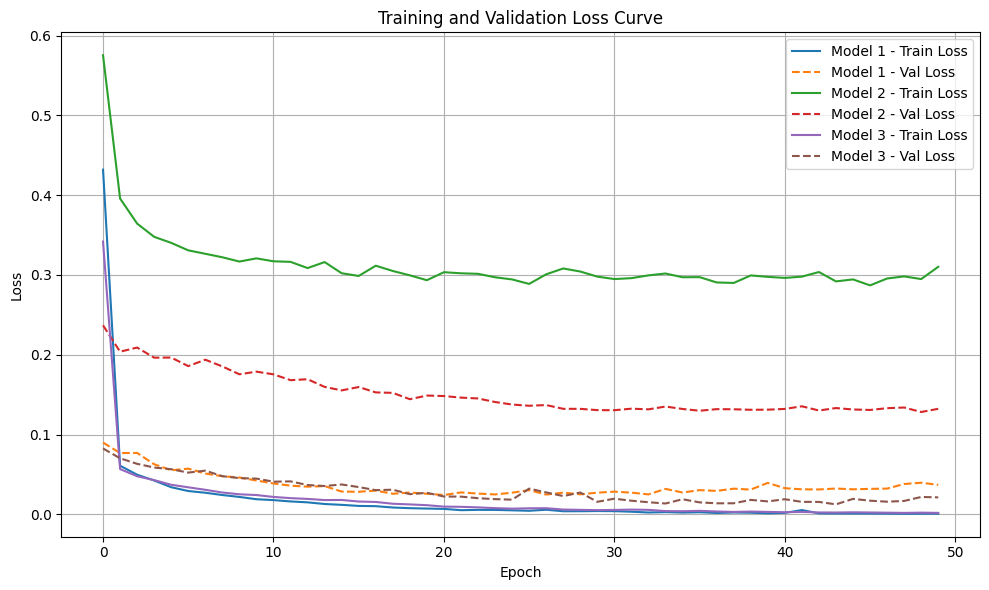

2025-07-09 11:57:20,244 - INFO - Cleaning up models...
2025-07-09 11:57:21,599 - INFO - Fold 10/10
2025-07-09 11:57:25,212 - INFO - Starting dimensionality reduction...


0:	learn: 0.9261208	total: 460ms	remaining: 1m 31s
1:	learn: 0.7955391	total: 628ms	remaining: 1m 2s
2:	learn: 0.6919513	total: 803ms	remaining: 52.7s
3:	learn: 0.6079936	total: 978ms	remaining: 47.9s
4:	learn: 0.5383431	total: 1.16s	remaining: 45.1s
5:	learn: 0.4795445	total: 1.32s	remaining: 42.8s
6:	learn: 0.4284512	total: 1.5s	remaining: 41.5s
7:	learn: 0.3850278	total: 1.68s	remaining: 40.4s
8:	learn: 0.3470228	total: 1.86s	remaining: 39.4s
9:	learn: 0.3130810	total: 2.03s	remaining: 38.6s
10:	learn: 0.2838934	total: 2.21s	remaining: 38s
11:	learn: 0.2582200	total: 2.38s	remaining: 37.2s
12:	learn: 0.2354202	total: 2.55s	remaining: 36.7s
13:	learn: 0.2150770	total: 2.72s	remaining: 36.1s
14:	learn: 0.1969056	total: 2.9s	remaining: 35.8s
15:	learn: 0.1808642	total: 3.07s	remaining: 35.3s
16:	learn: 0.1659487	total: 3.26s	remaining: 35.1s
17:	learn: 0.1532775	total: 3.43s	remaining: 34.7s
18:	learn: 0.1418240	total: 3.6s	remaining: 34.3s
19:	learn: 0.1310008	total: 3.77s	remaining: 

2025-07-09 11:58:06,483 - INFO - Calculating SHAP values...
2025-07-09 11:58:56,758 - INFO - SHAP values: Multiclass (3D Array), Shape: (3290, 22277, 3)
2025-07-09 11:58:59,206 - INFO - Type of shap_importance: <class 'numpy.ndarray'>
2025-07-09 11:58:59,206 - INFO - Shape of shap_importance: (22277,)
2025-07-09 11:58:59,206 - INFO - Type of X.columns: <class 'pandas.core.indexes.base.Index'>
2025-07-09 11:58:59,206 - INFO - Shape of X.columns: (22277,)
2025-07-09 11:58:59,206 - INFO - Length comparison: len(X.columns)=22277, len(shap_importance)=22277
2025-07-09 11:58:59,221 - INFO - SHAP values calculated.
2025-07-09 11:58:59,221 - INFO - Saved reduced data to cnn_ensemble_reduced_data_fold_9.pkl
2025-07-09 11:58:59,221 - INFO - Dimensionality reduction completed in 94.01 seconds.


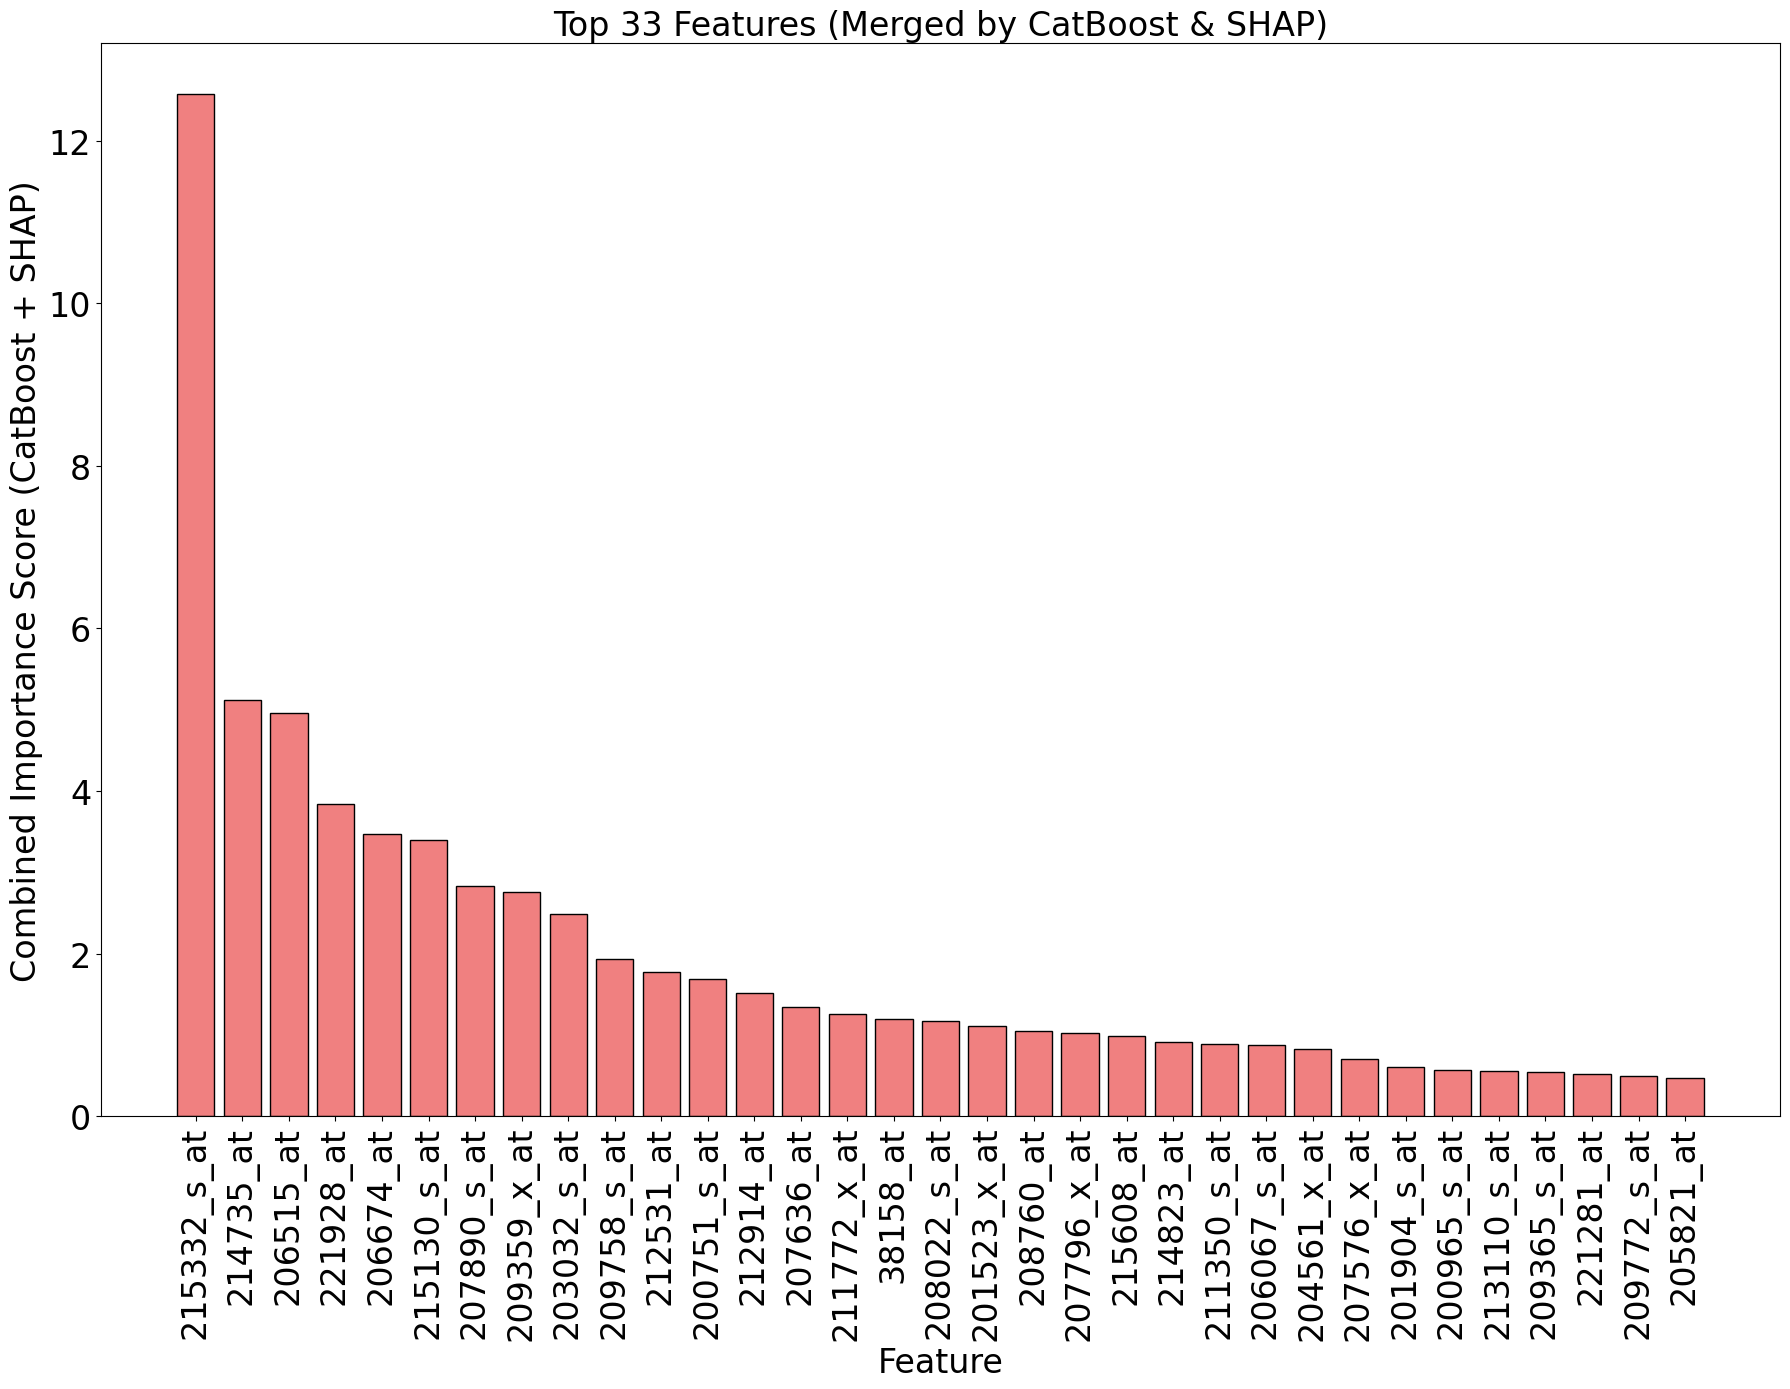

2025-07-09 11:59:00,235 - INFO - Training CNN Ensemble...
2025-07-09 11:59:00,409 - INFO - Fitting CNN Models...
2025-07-09 12:02:06,128 - INFO - CNN Ensemble trained in 185.72 seconds.
2025-07-09 12:02:06,128 - INFO - Predicting with CNN Models...
2025-07-09 12:02:07,648 - INFO - CNN Ensemble predicted in 1.52 seconds.
2025-07-09 12:02:07,664 - INFO - Calculating Evaluation Metrics...
2025-07-09 12:02:07,680 - INFO - Evaluation metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'confusion_matrix': [[71, 0, 0], [0, 266, 0], [0, 0, 28]]}


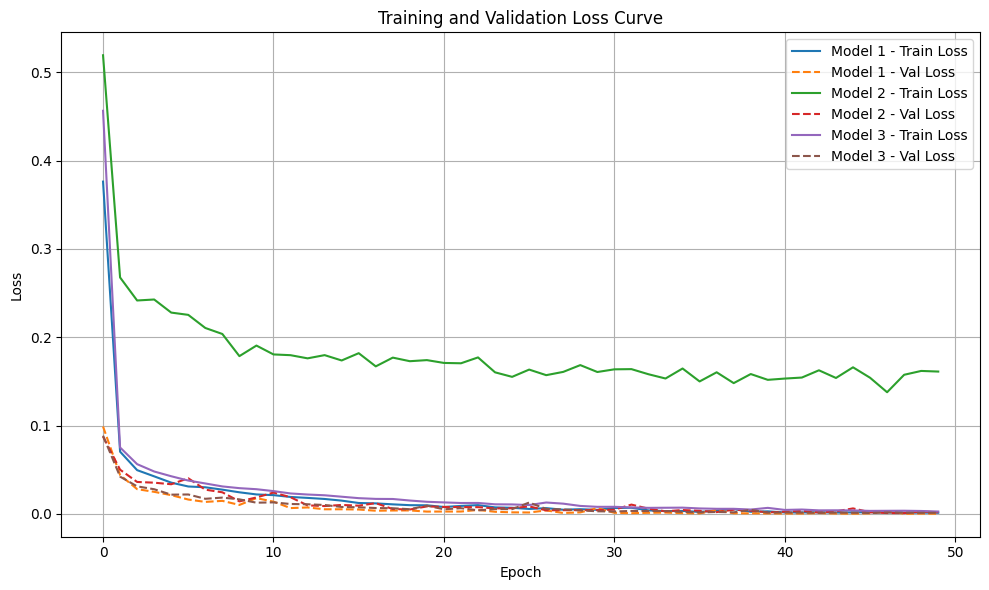

2025-07-09 12:02:08,019 - INFO - Cleaning up models...
2025-07-09 12:02:09,416 - INFO - --- Cross-Validation Completed ---
2025-07-09 12:02:09,416 - INFO - Average CNN Ensemble Metrics: {'accuracy': 0.9956239239464033, 'precision': 0.9956051896711864, 'recall': 0.9948796808712185, 'f1_score': 0.9952211007918846, 'confusion_matrix': [[697, 9, 0], [7, 2661, 0], [0, 0, 281]]}


Fold 1: Training time = 135.63 s, Prediction time = 1.24 s
Fold 2: Training time = 163.61 s, Prediction time = 1.59 s
Fold 3: Training time = 55.66 s, Prediction time = 0.56 s
Fold 4: Training time = 137.26 s, Prediction time = 1.69 s
Fold 5: Training time = 195.07 s, Prediction time = 1.88 s
Fold 6: Training time = 160.42 s, Prediction time = 1.27 s
Fold 7: Training time = 190.56 s, Prediction time = 1.50 s
Fold 8: Training time = 177.66 s, Prediction time = 0.59 s
Fold 9: Training time = 189.05 s, Prediction time = 1.24 s
Fold 10: Training time = 185.72 s, Prediction time = 1.52 s

Average training time: 159.07 s
Average prediction time: 1.31 s


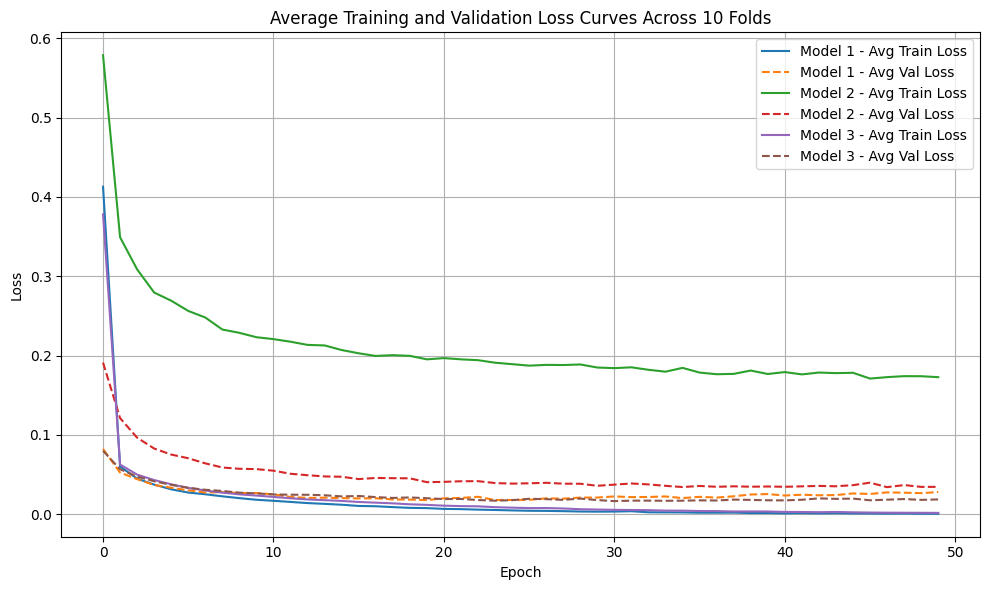

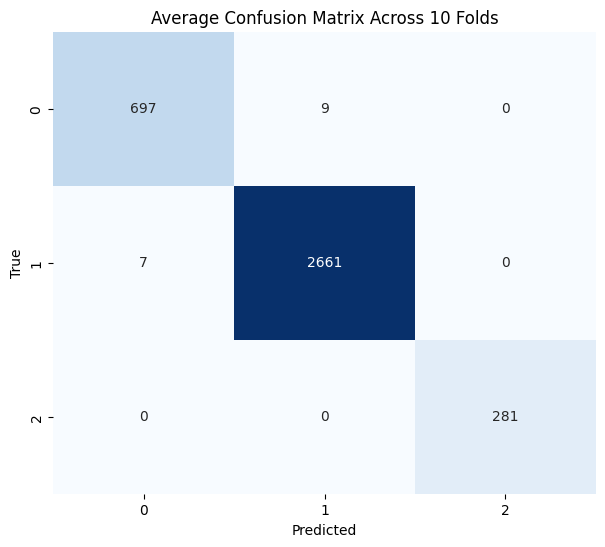

2025-07-09 12:02:09,958 - INFO - Total cross-validation execution time: 2729.34 seconds


In [10]:
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

if __name__ == '__main__':
    total_start_time = time.time()
    data_path = 'C:/Class/HK6/IPrj/Datasets/merged_AML_ALL.csv'

    data, X_train, y_train, X_test, y_test = load_and_preprocess_data_and_split(data_path)

    X = pd.concat([X_train, X_test], axis=0)
    y = pd.concat([y_train, y_test], axis=0)


    params_cnn = {
        'learning_rate': 0.001,
        'epochs': 50,
        'batch_size': 32,
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    all_metrics = []
    all_training_times = []
    all_prediction_times = []
    all_histories = []

    for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
        logging.info(f"Fold {fold + 1}/{kf.get_n_splits()}")

        X_fold_train, X_fold_val = X.iloc[train_index], X.iloc[val_index]
        y_fold_train, y_fold_val = y.iloc[train_index], y.iloc[val_index]


        X_fold_train_reduced, selected_features, top_features_catboost, top_features_shap = reduce_dimensionality(
            X_fold_train.copy(), y_fold_train.copy(),
            save_path=f'cnn_ensemble_reduced_data_fold_{fold}.pkl'
        )
        X_fold_val_reduced = X_fold_val[selected_features]

        metrics_cnn, training_time, prediction_time, histories = train_and_evaluate_cnn_ensemble(
            X_fold_train_reduced, y_fold_train, X_fold_val_reduced, y_fold_val,
            params_cnn
        )
        all_metrics.append(metrics_cnn)
        all_training_times.append(training_time)
        all_prediction_times.append(prediction_time)
        all_histories.append(histories)

    avg_metrics = {}
    for metric in all_metrics[0]:
        if metric != 'confusion_matrix':
            avg_metrics[metric] = np.mean([fold_metrics[metric] for fold_metrics in all_metrics])
        else:
            avg_cm = np.sum([np.array(fold_metrics[metric]) for fold_metrics in all_metrics], axis=0)
            avg_metrics[metric] = avg_cm.tolist()

    logging.info("--- Cross-Validation Completed ---")
    logging.info(f"Average CNN Ensemble Metrics: {avg_metrics}")

    for fold, (train_t, pred_t) in enumerate(zip(all_training_times, all_prediction_times), 1):
        print(f"Fold {fold}: Training time = {train_t:.2f} s, Prediction time = {pred_t:.2f} s")
    
    print(f"\nAverage training time: {np.mean(all_training_times):.2f} s")
    print(f"Average prediction time: {np.mean(all_prediction_times):.2f} s")
    
    
    # Calculate average loss curves
    summed_train_loss = {f'model_{i+1}': np.zeros(epochs) for i in range(3)}
    summed_val_loss = {f'model_{i+1}': np.zeros(epochs) for i in range(3)}

    for fold_histories in all_histories:
        for i, history in enumerate(fold_histories):
            if history is not None: 
                # Ensure that the history lengths match 'epochs'. 
                train_loss_data = np.array(history.history['loss'])
                val_loss_data = np.array(history.history['val_loss'])
                
                # Take minimum length in case of early stopping/variations
                min_len = min(len(train_loss_data), len(val_loss_data), epochs) 
                
                summed_train_loss[f'model_{i+1}'] += train_loss_data[:min_len]
                summed_val_loss[f'model_{i+1}'] += val_loss_data[:min_len]

    # Calculate average
    avg_train_loss = {k: v / kf.n_splits for k, v in summed_train_loss.items()}
    avg_val_loss = {k: v / kf.n_splits for k, v in summed_val_loss.items()}

    # Plot average loss curves
    plt.figure(figsize=(10, 6))
    for i in range(3):
        plt.plot(avg_train_loss[f'model_{i+1}'], label=f'Model {i+1} - Avg Train Loss')
        plt.plot(avg_val_loss[f'model_{i+1}'], label=f'Model {i+1} - Avg Val Loss', linestyle='--')
    
    plt.title("Average Training and Validation Loss Curves Across 10 Folds")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    
    if 'confusion_matrix' in avg_metrics:
        cm_to_plot = np.array(avg_metrics['confusion_matrix'])
        labels = all_possible_labels 
        
        plt.figure(figsize=(7, 6))
        sns.heatmap(cm_to_plot, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=labels, yticklabels=labels, cbar=False)
        plt.title("Average Confusion Matrix Across 10 Folds")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()
    else:
        logging.warning("Confusion matrix not found in average metrics for plotting.")

    total_end_time = time.time()    
    total_duration = total_end_time - total_start_time
    logging.info(f"Total cross-validation execution time: {total_duration:.2f} seconds")

In [11]:
selected_features 

['213110_s_at',
 '206067_s_at',
 '207796_x_at',
 '208760_at',
 '214823_at',
 '207636_at',
 '206674_at',
 '221928_at',
 '209772_s_at',
 '201523_x_at',
 '221281_at',
 '209758_s_at',
 '205821_at',
 '203032_s_at',
 '209359_x_at',
 '200965_s_at',
 '207890_s_at',
 '215608_at',
 '212914_at',
 '212531_at',
 '211772_x_at',
 '206515_at',
 '215332_s_at',
 '200751_s_at',
 '211350_s_at',
 '209365_s_at',
 '207576_x_at',
 '208022_s_at',
 '38158_at',
 '201904_s_at',
 '214735_at',
 '204561_x_at',
 '215130_s_at']

In [10]:
import cv2

# Load the image (change the path to your image file)
image = cv2.imread("C:/Users/Kim_Ngan/OneDrive/Pictures/indv pro/loss_curve.png")
# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Save the grayscale image
cv2.imwrite('C:/Users/Kim_Ngan/OneDrive/Pictures/indv pro/grayscale_loss_curve.png', gray_image)

print("Image saved as grayscale_loss_curve.png")



Image saved as grayscale_loss_curve.png


In [11]:
import cv2

# Load the image (change the path to your image file)
image = cv2.imread("C:/Users/Kim_Ngan/OneDrive/Pictures/indv pro/confusion_max.png")
# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Save the grayscale image
cv2.imwrite('C:/Users/Kim_Ngan/OneDrive/Pictures/indv pro/grayscale_confusion_max.png', gray_image)

print("Image saved as grayscale_loss_curve.png")

Image saved as grayscale_loss_curve.png
